# Import packages & functions

In [ ]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator

# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
import sgm
from pkgs.MindEyeV2.src.generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder # bigG embedder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import pkgs.MindEyeV2.src.utils as utils

import lovely_tensors as lt
lt.monkey_patch()

from csng.data import get_dataloaders
from csng.utils.mix import seed_all
from csng.utils.data import crop

DATA_PATH_BRAINREADER = os.path.join(os.environ["DATA_PATH"], "brainreader")
DATA_PATH_CAT_V1 = os.path.join(os.environ["DATA_PATH"], "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
DATA_PATH_MINDEYE = os.path.join(os.environ["DATA_PATH"], "mindeye")
DATA_PATH_MINDEYE_CACHE = os.path.join(DATA_PATH_MINDEYE, "cache")
print(f"{DATA_PATH_BRAINREADER=}\n{DATA_PATH_MINDEYE=}\n{DATA_PATH_MINDEYE_CACHE=}")

!nvidia-smi

# Configurations

In [ ]:
cfg = {
    "device": "cuda",
    "data_type": torch.float32,
    "seed": 0,
    "data": {"mixing_strategy": "parallel_min", "max_training_batches": None},
    "wandb": {"project": os.environ["WANDB_PROJECT"], "group": "mindeye"},
    "data_name": "mouse_v1",
    "crop_wins": {
        "mouse_v1": (22, 36),
        "cat_v1": (20, 20),
        "brainreader_mouse": None,
    },
}

### setup data config
# cfg["data"][cfg["data_name"]] = {
#     "device": cfg["device"],
#     "mixing_strategy": cfg["data"]["mixing_strategy"],
#     "max_batches": None,
#     "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
#     "batch_size": 1,
#     # "sessions": (subj_list := list(range(1, 23))),
#     "sessions": (subj_list := [1,2,3,4,5,6,7,8]),
#     "resize_stim_to": (36, 64),
#     "normalize_stim": True,
#     "normalize_resp": True,
#     "div_resp_by_std": True,
#     "clamp_neg_resp": False,
#     "additional_keys": None,
#     "avg_test_resp": True,
#     "drop_last": False,
# }

cfg["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            os.path.join(DATA_PATH_MOUSE_V1, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-1
            # os.path.join(DATA_PATH_MOUSE_V1, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-2
            # os.path.join(DATA_PATH_MOUSE_V1, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-3
            # os.path.join(DATA_PATH_MOUSE_V1, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-4
            # os.path.join(DATA_PATH_MOUSE_V1, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # M-5
        ],
        "normalize": True,
        "z_score_responses": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": False,
        "batch_size": 8,
        "drop_last": True,
        "seed": cfg["seed"],
        "use_cache": False,
    },
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": cfg["device"],
}
cfg["data"]["mouse_v1"]["batch_size"] = cfg["data"]["mouse_v1"]["dataset_config"]["batch_size"]
subj_list = [
    '-'.join(path.split("/")[-1].replace("static", "").split("-")[:3])
    for path in cfg["data"]["mouse_v1"]["dataset_config"]["paths"]
]
print(f"{subj_list=}")

# cfg["data"]["cat_v1"] = {
#     "dataset_config": {
#         "train_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "train"),
#         "val_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "val"),
#         "test_path": os.path.join(DATA_PATH_CAT_V1, "datasets", "test"),
#         "image_size": [50, 50],
#         "crop": False,
#         "batch_size": 8,
#         "stim_keys": ("stim",),
#         "resp_keys": ("exc_resp", "inh_resp"),
#         "return_coords": True,
#         "return_ori": False,
#         "coords_ori_filepath": os.path.join(DATA_PATH_CAT_V1, "pos_and_ori.pkl"),
#         "cached": False,
#         "stim_normalize_mean": 46.143,
#         "stim_normalize_std": 24.960,
#         "resp_normalize_mean": torch.load(
#             os.path.join(DATA_PATH_CAT_V1, "responses_mean.pt")
#         ),
#         "resp_normalize_std": torch.load(
#             os.path.join(DATA_PATH_CAT_V1, "responses_std.pt")
#         ),
#         "clamp_neg_resp": False,
#     },
# }
# cfg["data"]["cat_v1"]["batch_size"] = cfg["data"]["cat_v1"]["dataset_config"]["batch_size"]
# subj_list = ["cat_v1"]
# print(f"{subj_list=}")


### setup model config
cfg["model"] = {
    "model_name": (model_name := "csng_mouse_v1__17-03-25_01-23"),
    "cache_dir": DATA_PATH_MINDEYE_CACHE,
    "outdir": f'{DATA_PATH_MINDEYE}/train_logs/{model_name}',
    "evalsdir": f'{DATA_PATH_MINDEYE}/evals/{model_name}',
    "ckpt_saving": True,
    "ckpt_interval": 1,

    # "subj_list": [6], # list(range(1, 23))
    # "num_voxels_list": [8587],
    # "num_voxels": {
    #     f'subj06': 8587,
    # },

    "subj_list": subj_list,
    # "num_voxels_list": (num_voxels_list := [dset.n_neurons for dset in get_dataloaders(config=cfg)[0]["train"][cfg["data_name"]].datasets]),
    "num_voxels_list": (num_voxels_list := [next(iter(dl))[1].shape[-1] for dl in get_dataloaders(config=cfg)[0]["train"][cfg["data_name"]].dataloaders]),
    "num_voxels": {
        (f"subj{subj:02d}" if subj.isnumeric() else f"subj{subj}"): num_voxels
        for subj, num_voxels in zip(subj_list, num_voxels_list)
    },
    "hidden_dim": 768,
    "n_blocks": 4,
    "clip_scale": 1.,
    "use_prior": True,
    "prior_scale": 30,
    "num_epochs": 100,
    "num_iterations_per_epoch": 500,
    # "mixup_pct": 0.33,
    "mixup_pct": 0.,
    "blurry_recon": True,
    "blur_scale": 0.54,
    "use_image_aug": False,
}

In [ ]:
### create dirs
os.makedirs(cfg["model"]["outdir"], exist_ok=True)
os.makedirs(cfg["model"]["cache_dir"], exist_ok=True)
print(cfg["model"]["outdir"])

# Prep data, models, and dataloaders

In [ ]:
seed_all(cfg["seed"])
dls, _ = get_dataloaders(config=cfg)
train_dl, val_dl = dls["train"][cfg["data_name"]], dls["val"][cfg["data_name"]]
train_dls = {subj_name: dl for subj_name, dl in zip(cfg["model"]["num_voxels"].keys(), train_dl.dataloaders)}
display(train_dls)

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
cfg["model"]["num_samples_per_epoch"] = sum(len(dl) * dl.batch_size for dl in train_dls.values())
cfg["model"]["num_iterations_per_epoch"] = cfg["model"]["num_samples_per_epoch"] // (cfg["data"][cfg["data_name"]]["batch_size"] * len(cfg["model"]["subj_list"]))

## Load models

### CLIP image embeddings  model

In [5]:
cfg["model"]["clip_img_embedder_arch"] = "ViT-bigG-14"
cfg["model"]["clip_img_embedder_version"] = "laion2b_s39b_b160k"
cfg["model"]["clip_seq_dim"] = 256
cfg["model"]["clip_emb_dim"] = 1664

clip_img_embedder = FrozenOpenCLIPImageEmbedder(
    arch=cfg["model"]["clip_img_embedder_arch"],
    version=cfg["model"]["clip_img_embedder_version"],
    output_tokens=True,
    only_tokens=True,
    cache_dir=cfg["model"]["cache_dir"],
)
clip_img_embedder.to(cfg["device"])

FrozenOpenCLIPImageEmbedder(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1664, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (patch_dropout): Identity()
      (ln_pre): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): ModuleList(
          (0-47): 48 x ResidualAttentionBlock(
            (ln_1): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1664, out_features=1664, bias=True)
            )
            (ls_1): Identity()
            (ln_2): LayerNorm((1664,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1664, out_features=8192, bias=True)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=8192, out_features=1664, bias=True)
            )
            (ls_2): Identity()


### SD VAE

In [6]:
if cfg["model"]["blurry_recon"]:
    ### SD VAE
    from diffusers import AutoencoderKL
    cfg["model"]["autoenc"] = {
        "down_block_types": ['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
        "up_block_types": ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
        "block_out_channels": [128, 256, 512, 512],
        "layers_per_block": 2,
        "sample_size": 256,
    }
    autoenc = AutoencoderKL(**cfg["model"]["autoenc"])
    autoenc.load_state_dict(torch.load(f'{cfg["model"]["cache_dir"]}/sd_image_var_autoenc.pth'))
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(cfg["device"])
    utils.count_params(autoenc)

    ### VICRegL ConvNext-XL
    from pkgs.MindEyeV2.src.autoencoder.convnext import ConvnextXL
    cnx = ConvnextXL(f'{cfg["model"]["cache_dir"]}/convnext_xlarge_alpha0.75_fullckpt.pth')
    cnx.requires_grad_(False)
    cnx.eval()
    cnx.to(cfg["device"])
    utils.count_params(cnx)

    import kornia
    from kornia.augmentation.container import AugmentationSequential
    mean = torch.tensor([0.485, 0.456, 0.406]).to(cfg["device"]).reshape(1,3,1,1)
    std = torch.tensor([0.228, 0.224, 0.225]).to(cfg["device"]).reshape(1,3,1,1)
    blur_augs = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1, p=0.8),
        kornia.augmentation.RandomGrayscale(p=0.1),
        kornia.augmentation.RandomSolarize(p=0.1),
        kornia.augmentation.RandomResizedCrop((224,224), scale=(.9,.9), ratio=(1,1), p=1.0),
        data_keys=["input"],
    )

param counts:
83,653,863 total
0 trainable
param counts:
349,687,808 total
0 trainable


### MindEye modules

In [7]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    
    def forward(self, x):
        return x

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer to enable regularization
    def __init__(self, input_sizes, out_features): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
            torch.nn.Linear(input_size, out_features) for input_size in input_sizes
        ])
    
    def forward(self, x, subj_idx):
        out = self.linears[subj_idx](x[:,0]).unsqueeze(1)
        return out

In [8]:
### init model
model = MindEyeModule()
model.ridge = RidgeRegression(cfg["model"]["num_voxels_list"], out_features=cfg["model"]["hidden_dim"])
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,1,cfg["model"]["num_voxels_list"][0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
6,430,464 total
6,430,464 trainable
param counts:
6,430,464 total
6,430,464 trainable
torch.Size([2, 1, 8372]) torch.Size([2, 1, 768])


In [9]:
from pkgs.MindEyeV2.src.models import BrainNetwork

### backbone
cfg["model"]["brainnetwork"] = {
    "h": cfg["model"]["hidden_dim"],
    "in_dim": cfg["model"]["hidden_dim"],
    "seq_len": 1,
    "n_blocks": cfg["model"]["n_blocks"],
    "clip_size": cfg["model"]["clip_emb_dim"],
    "out_dim": cfg["model"]["clip_emb_dim"] * cfg["model"]["clip_seq_dim"],
    "blurry_recon": cfg["model"]["blurry_recon"],
    "clip_scale": cfg["model"]["clip_scale"],
}
model.backbone = BrainNetwork(**cfg["model"]["brainnetwork"])
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,1,cfg["model"]["hidden_dim"]))
print("b.shape",b.shape)

backbone_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

param counts:
345,356,284 total
345,356,284 trainable
param counts:
351,786,748 total
351,786,748 trainable
b.shape torch.Size([2, 1, 768])
torch.Size([2, 256, 1664]) torch.Size([2, 256, 1664]) torch.Size([2, 4, 28, 28]) torch.Size([2, 49, 512])


### Adding diffusion prior + unCLIP if use_prior=True

In [10]:
if cfg["model"]["use_prior"]:
    from pkgs.MindEyeV2.src.models import *

    ### setup diffusion prior network
    cfg["model"]["out_dim"] = cfg["model"]["clip_emb_dim"]
    cfg["model"]["depth"] = 5
    cfg["model"]["dim_head"] = 52
    cfg["model"]["heads"] = cfg["model"]["clip_emb_dim"] // cfg["model"]["dim_head"]
    cfg["model"]["timesteps"] = 100
    cfg["model"]["prior_network"] = {
        "dim": cfg["model"]["out_dim"],
        "depth": cfg["model"]["depth"],
        "dim_head": cfg["model"]["dim_head"],
        "heads": cfg["model"]["heads"],
        "causal": False,
        "num_tokens": cfg["model"]["clip_seq_dim"],
        "learned_query_mode": "pos_emb",
        "normformer": True,
    }
    cfg["model"]["brain_diffusion_prior"] = {
        "image_embed_dim": cfg["model"]["out_dim"],
        "condition_on_text_encodings": False,
        "timesteps": cfg["model"]["timesteps"],
        "cond_drop_prob": 0.2,
        "image_embed_scale": None,
    }

    prior_network = PriorNetwork(**cfg["model"]["prior_network"])
    model.diffusion_prior = BrainDiffusionPrior(net=prior_network, **cfg["model"]["brain_diffusion_prior"])
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)

param counts:
220,955,800 total
220,955,784 trainable
param counts:
572,742,548 total
572,742,532 trainable


### Setup optimizer / lr / ckpt saving

In [11]:
cfg["model"]["optimization"] = {
    "no_decay": ['bias', 'LayerNorm.bias', 'LayerNorm.weight'],
    "max_lr": 3e-4,
    "lr_scheduler_type": 'cycle',
}

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 1e-2},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 0.0},
]
if cfg["model"]["use_prior"]:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 1e-2},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in cfg["model"]["optimization"]["no_decay"])], 'weight_decay': 0.0}
    ])

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=cfg["model"]["optimization"]["max_lr"])

if cfg["model"]["optimization"]["lr_scheduler_type"] == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=cfg["model"]["num_epochs"]*cfg["model"]["num_iterations_per_epoch"],
        last_epoch=-1
    )
elif cfg["model"]["optimization"]["lr_scheduler_type"] == 'cycle':
    cfg["model"]["optimization"]["total_steps"] = int(np.floor(cfg["model"]["num_epochs"]*cfg["model"]["num_iterations_per_epoch"]))
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=cfg["model"]["optimization"]["max_lr"],
        total_steps=cfg["model"]["optimization"]["total_steps"],
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/cfg["model"]["num_epochs"],
    )
    print("total_steps", cfg["model"]["optimization"]["total_steps"])

def save_ckpt(tag):
    ckpt_path = cfg["model"]["outdir"]+f'/{tag}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'train_losses': losses,
        'test_losses': test_losses,
        'lrs': lrs,
        "cfg": cfg,
        "best": best,
    }, ckpt_path)
    print(f"\n---saved {cfg['model']['outdir']}/{tag} ckpt!---\n")

def load_ckpt(tag):
    ckpt_path = cfg["model"]["outdir"]+f'/{tag}.pth'
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    epoch = checkpoint['epoch']
    losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    lrs = checkpoint['lrs']
    best = checkpoint['best']
    optimizer.zero_grad()
    print(f"\n---loaded {cfg['model']['outdir']}/{tag} ckpt!---\n")
    return epoch, losses, test_losses, lrs, checkpoint["cfg"], best

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 55900

Done with model preparations!
param counts:
572,742,548 total
572,742,532 trainable


In [12]:
model

MindEyeModule(
  (ridge): RidgeRegression(
    (linears): ModuleList(
      (0): Linear(in_features=8372, out_features=768, bias=True)
    )
  )
  (backbone): BrainNetwork(
    (mixer_blocks1): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=768, out_features=768, bias=True)
        )
      )
    )
    (mixer_blocks2): ModuleList(
      (0-3): 4 x Sequential(
        (0): LayerNorm((1,), eps=1e-05, elementwise_affine=True)
        (1): Sequential(
          (0): Linear(in_features=1, out_features=1, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.15, inplace=False)
          (3): Linear(in_features=1, out_features=1, bias=True)
        )
      )
    )
    (backbone_linear): Linear(in_feat

In [ ]:
### fine-tuning
ckpt_path = '/scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1_all/best.pth'
checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.zero_grad()

In [ ]:
epoch, losses, test_losses, lrs, cfg, best = load_ckpt("last")

In [ ]:
model.to(cfg["device"])
optimizer.zero_grad()
epoch, losses, test_losses, lrs, cfg, best = load_ckpt("last")

# Weights and Biases

In [16]:
if cfg.get("wandb", None) is not None: # only use main process for wandb logging
    import wandb
    wandb_log = wandb.init(
        id=cfg["model"]["model_name"],
        name=cfg["model"]["model_name"],
        config=cfg,
        resume="allow",
        **cfg["wandb"],
    )
else:
    wandb_log = False

wandb: Currently logged in as: johnny1188 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# Main

In [17]:
### img transform (1x36x64 -> 3x224x224)
img_tform = transforms.Compose([
    transforms.Lambda(lambda x: crop(x, cfg["crop_wins"][cfg["data_name"]])),
    transforms.Resize((224, 224), antialias=True),
    transforms.Lambda(lambda x: x.repeat(1, 3, 1, 1)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
if cfg["model"]["use_image_aug"]:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

[E0/100 I0/559]


/home/sobotka/miniconda3/envs/mindeye/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  Loss 30.048303604125977
[E0/100 I50/559]
  Loss 15.951108932495117
[E0/100 I100/559]
  Loss 17.662696838378906
[E0/100 I150/559]
  Loss 12.853514671325684
[E0/100 I200/559]
  Loss 13.215180397033691
[E0/100 I250/559]
  Loss 12.479981422424316
[E0/100 I300/559]
  Loss 10.721430778503418
[E0/100 I350/559]
  Loss 10.442138671875
[E0/100 I400/559]
  Loss 9.286359786987305
[E0/100 I450/559]
  Loss 11.114359855651855
[E0/100 I500/559]
  Loss 7.245871543884277
[E0/100 I550/559]
  Loss 10.157364845275879

---Evaluating---


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/best ckpt!---



  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 0/100 [19:18<?, ?it/s, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b443f10>, test/blurry_pixcorr=0.477, test/loss=11.1, test/loss_clip_total=0.317, test/loss_prior=0.36, test/num_steps=1, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.908, train/blurry_pixcorr=0.638, train/bwd_pct_correct=0.993, train/fwd_pct_correct=0.999, train/loss=13.4, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 0 / 100


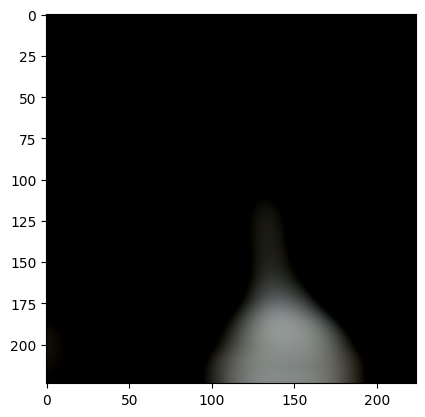

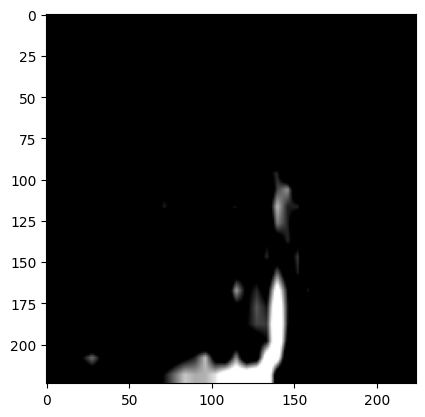

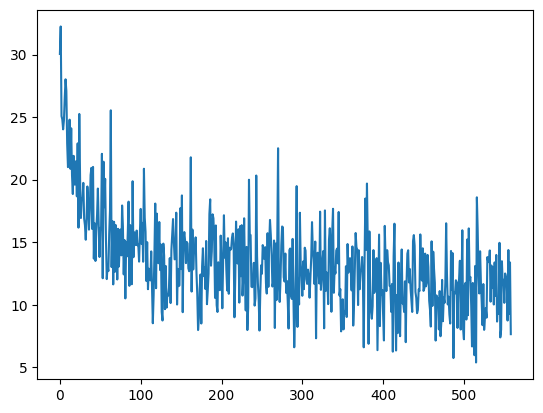

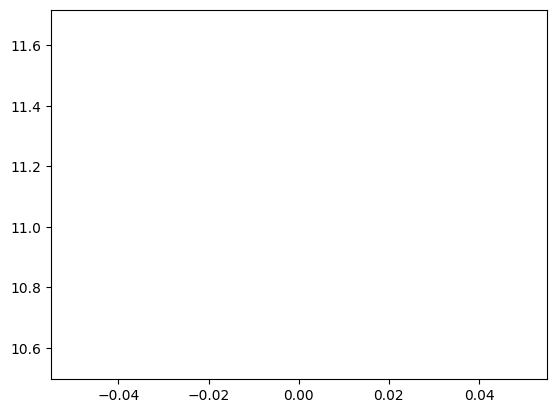

  1%|█████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 1/100 [19:25<32:03:34, 1165.80s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b443f10>, test/blurry_pixcorr=0.477, test/loss=11.1, test/loss_clip_total=0.317, test/loss_prior=0.36, test/num_steps=1, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.908, train/blurry_pixcorr=0.638, train/bwd_pct_correct=0.993, train/fwd_pct_correct=0.999, train/loss=13.4, train/lo

[E1/100 I0/559]
  Loss 9.617854118347168
[E1/100 I50/559]
  Loss 10.128377914428711
[E1/100 I100/559]
  Loss 15.384827613830566
[E1/100 I150/559]
  Loss 10.942350387573242
[E1/100 I200/559]
  Loss 11.123703002929688
[E1/100 I250/559]
  Loss 10.321170806884766
[E1/100 I300/559]
  Loss 8.685873985290527
[E1/100 I350/559]
  Loss 9.278411865234375
[E1/100 I400/559]
  Loss 8.478717803955078
[E1/100 I450/559]
  Loss 9.984890937805176
[E1/100 I500/559]
  Loss 6.737212657928467
[E1/100 I550/559]
  Loss 9.635765075683594

---Evaluating---


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/best ckpt!---



  1%|█████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 1/100 [35:48<32:03:34, 1165.80s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a9d1250>, test/blurry_pixcorr=0.478, test/loss=10.9, test/loss_clip_total=0.305, test/loss_prior=0.353, test/num_steps=2, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.902, train/blurry_pixcorr=0.642, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=10.9, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 1 / 100


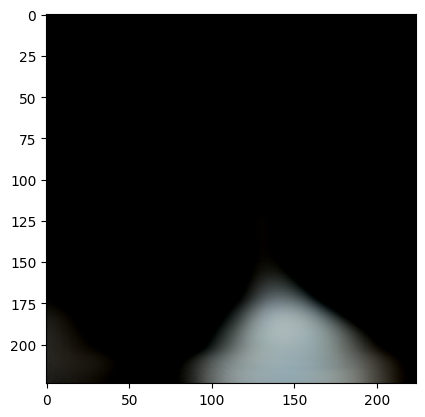

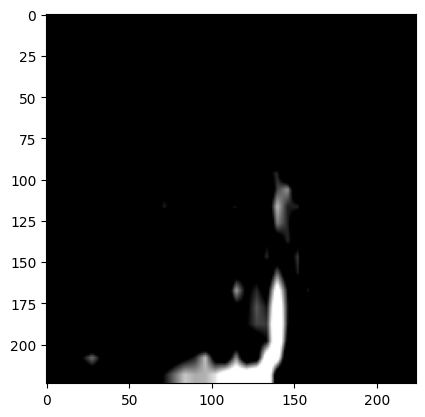

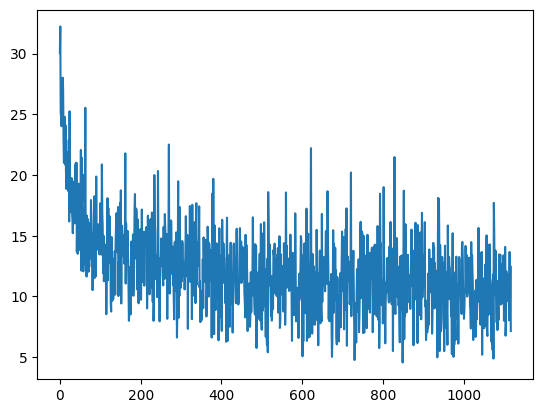

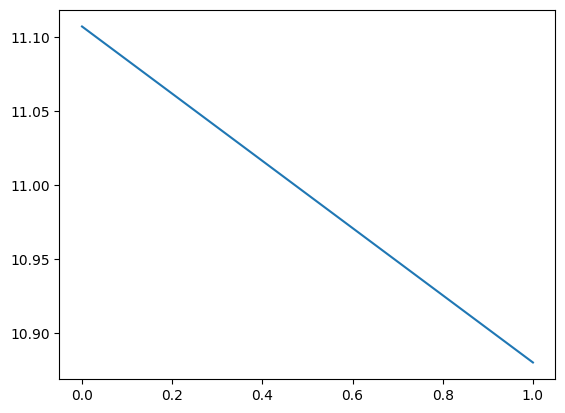

  2%|███████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 2/100 [35:55<28:54:59, 1062.24s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a9d1250>, test/blurry_pixcorr=0.478, test/loss=10.9, test/loss_clip_total=0.305, test/loss_prior=0.353, test/num_steps=2, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.902, train/blurry_pixcorr=0.642, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=10.9, train/lo

[E2/100 I0/559]
  Loss 9.108331680297852
[E2/100 I50/559]
  Loss 9.302865982055664
[E2/100 I100/559]
  Loss 14.609270095825195
[E2/100 I150/559]
  Loss 10.456230163574219
[E2/100 I200/559]
  Loss 10.687678337097168
[E2/100 I250/559]
  Loss 9.288880348205566
[E2/100 I300/559]
  Loss 7.581753253936768
[E2/100 I350/559]
  Loss 8.962271690368652
[E2/100 I400/559]
  Loss 7.953567028045654
[E2/100 I450/559]
  Loss 9.404096603393555
[E2/100 I500/559]
  Loss 6.595108985900879
[E2/100 I550/559]
  Loss 9.292121887207031

---Evaluating---



  2%|████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 2/100 [52:11<28:54:59, 1062.24s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2ab37b50>, test/blurry_pixcorr=0.477, test/loss=11, test/loss_clip_total=0.312, test/loss_prior=0.357, test/num_steps=3, test/test_bwd_pct_correct=0.904, test/test_fwd_pct_correct=0.9, train/blurry_pixcorr=0.66, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=10.3, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 2 / 100


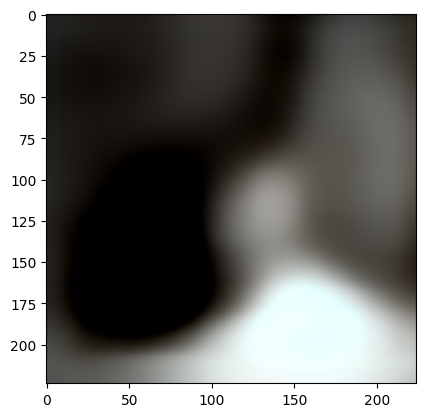

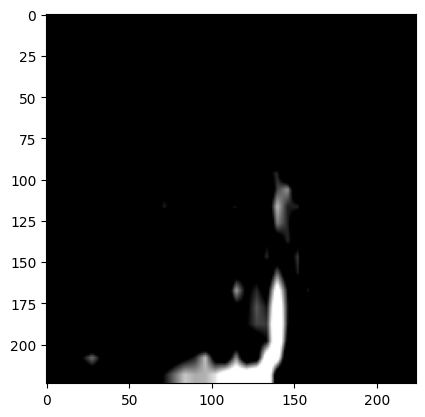

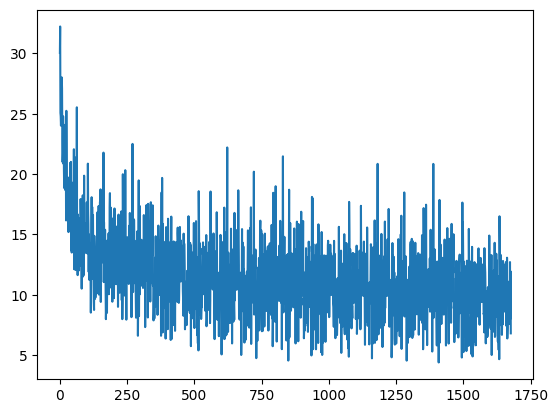

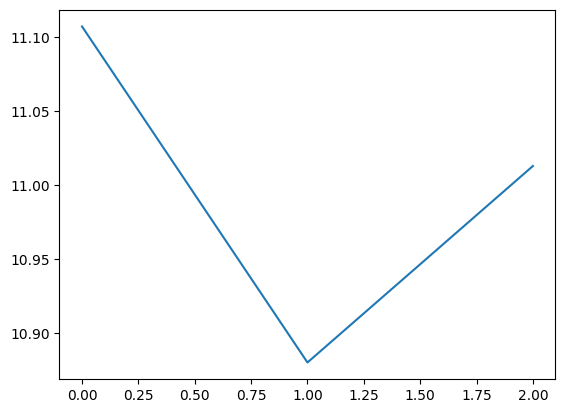

  3%|██████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 3/100 [52:18<27:38:54, 1026.13s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2ab37b50>, test/blurry_pixcorr=0.477, test/loss=11, test/loss_clip_total=0.312, test/loss_prior=0.357, test/num_steps=3, test/test_bwd_pct_correct=0.904, test/test_fwd_pct_correct=0.9, train/blurry_pixcorr=0.66, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=10.3, train/los

[E3/100 I0/559]
  Loss 8.845633506774902
[E3/100 I50/559]
  Loss 8.847840309143066
[E3/100 I100/559]
  Loss 13.963531494140625
[E3/100 I150/559]
  Loss 9.98830509185791
[E3/100 I200/559]
  Loss 10.397088050842285
[E3/100 I250/559]
  Loss 9.081233024597168
[E3/100 I300/559]
  Loss 7.0665998458862305
[E3/100 I350/559]
  Loss 8.63912582397461
[E3/100 I400/559]
  Loss 7.737417697906494
[E3/100 I450/559]
  Loss 9.110605239868164
[E3/100 I500/559]
  Loss 6.512702941894531
[E3/100 I550/559]
  Loss 9.254579544067383

---Evaluating---



  3%|█████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 3/100 [1:08:36<27:38:54, 1026.13s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a5f4490>, test/blurry_pixcorr=0.47, test/loss=11.2, test/loss_clip_total=0.316, test/loss_prior=0.362, test/num_steps=4, test/test_bwd_pct_correct=0.902, test/test_fwd_pct_correct=0.894, train/blurry_pixcorr=0.679, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.86, train/lo


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 3 / 100


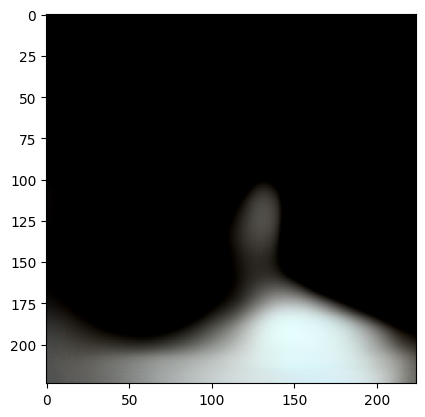

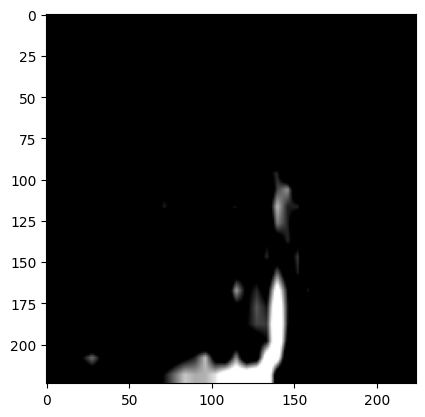

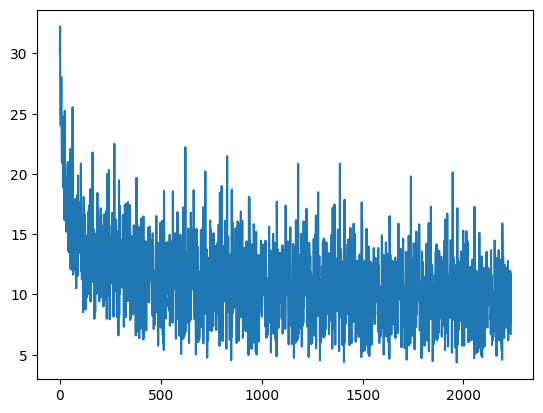

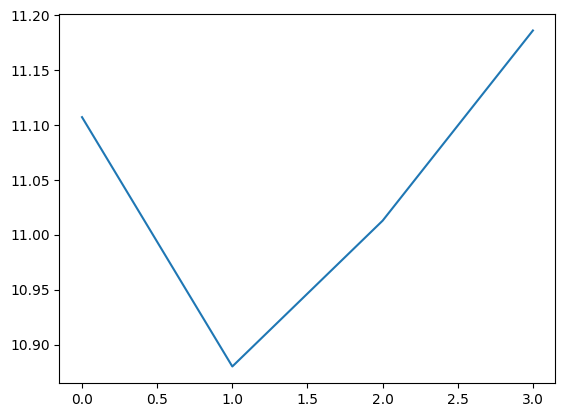

  4%|███████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 4/100 [1:08:43<26:55:32, 1009.71s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a5f4490>, test/blurry_pixcorr=0.47, test/loss=11.2, test/loss_clip_total=0.316, test/loss_prior=0.362, test/num_steps=4, test/test_bwd_pct_correct=0.902, test/test_fwd_pct_correct=0.894, train/blurry_pixcorr=0.679, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.86, train/lo

[E4/100 I0/559]
  Loss 8.694656372070312
[E4/100 I50/559]
  Loss 8.621052742004395
[E4/100 I100/559]
  Loss 13.603897094726562
[E4/100 I150/559]
  Loss 9.651305198669434
[E4/100 I200/559]
  Loss 10.117128372192383
[E4/100 I250/559]
  Loss 8.516672134399414
[E4/100 I300/559]
  Loss 6.625985145568848
[E4/100 I350/559]
  Loss 8.463541984558105
[E4/100 I400/559]
  Loss 7.520789623260498
[E4/100 I450/559]
  Loss 8.755155563354492
[E4/100 I500/559]
  Loss 6.392655849456787
[E4/100 I550/559]
  Loss 9.079937934875488

---Evaluating---



  4%|███████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 4/100 [1:24:59<26:55:32, 1009.71s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b7c3150>, test/blurry_pixcorr=0.474, test/loss=11.3, test/loss_clip_total=0.31, test/loss_prior=0.366, test/num_steps=5, test/test_bwd_pct_correct=0.9, test/test_fwd_pct_correct=0.902, train/blurry_pixcorr=0.693, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.49, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/ep4 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 4 / 100


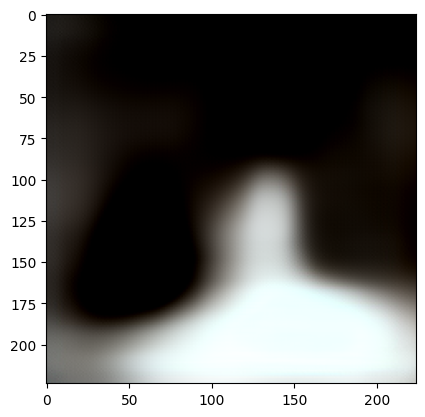

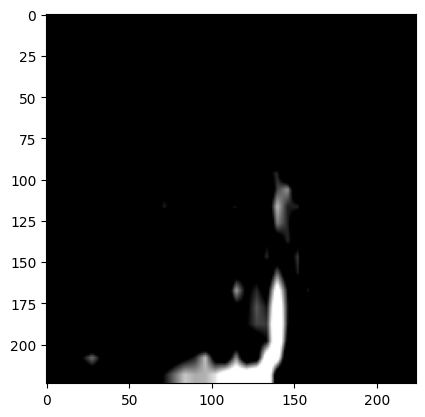

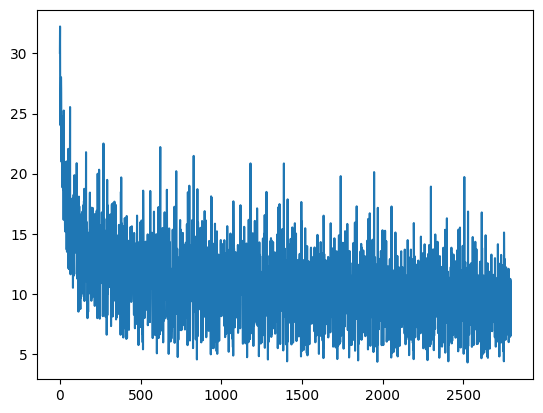

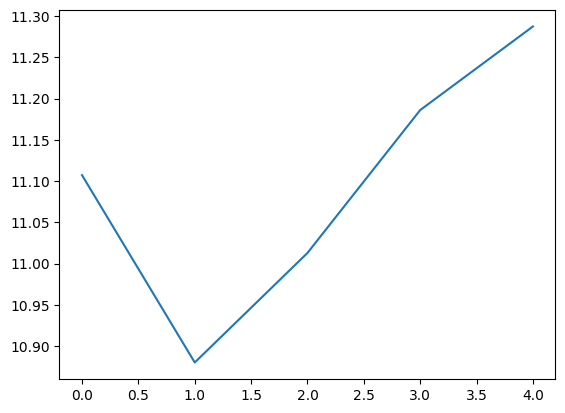

  5%|█████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 5/100 [1:25:12<26:27:17, 1002.50s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b7c3150>, test/blurry_pixcorr=0.474, test/loss=11.3, test/loss_clip_total=0.31, test/loss_prior=0.366, test/num_steps=5, test/test_bwd_pct_correct=0.9, test/test_fwd_pct_correct=0.902, train/blurry_pixcorr=0.693, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.49, train/loss

[E5/100 I0/559]
  Loss 8.535232543945312
[E5/100 I50/559]
  Loss 7.992430686950684
[E5/100 I100/559]
  Loss 13.244361877441406
[E5/100 I150/559]
  Loss 9.089184761047363
[E5/100 I200/559]
  Loss 9.833736419677734
[E5/100 I250/559]
  Loss 8.23596477508545
[E5/100 I300/559]
  Loss 6.290982246398926
[E5/100 I350/559]
  Loss 8.085930824279785
[E5/100 I400/559]
  Loss 7.144662380218506
[E5/100 I450/559]
  Loss 8.521270751953125
[E5/100 I500/559]
  Loss 6.201324462890625
[E5/100 I550/559]
  Loss 8.721894264221191

---Evaluating---



  5%|█████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 5/100 [1:41:29<26:27:17, 1002.50s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a891d50>, test/blurry_pixcorr=0.47, test/loss=11.4, test/loss_clip_total=0.312, test/loss_prior=0.369, test/num_steps=6, test/test_bwd_pct_correct=0.896, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.709, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.08, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 5 / 100


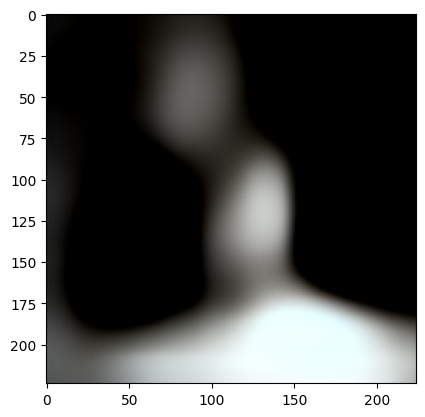

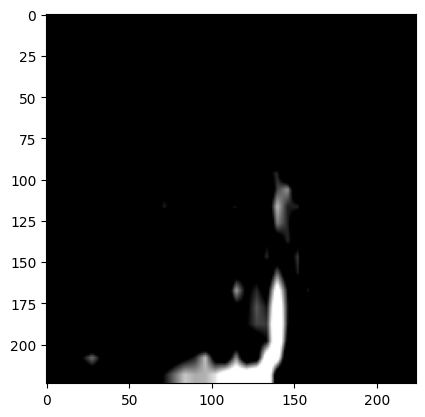

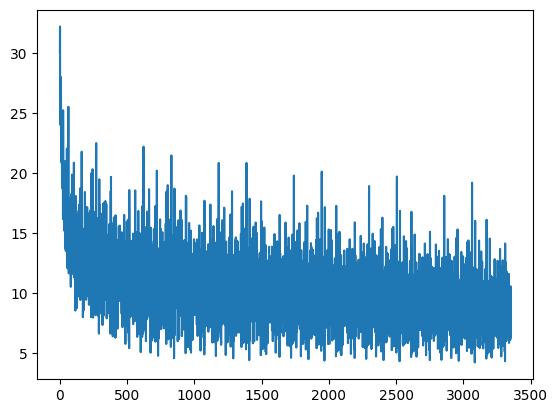

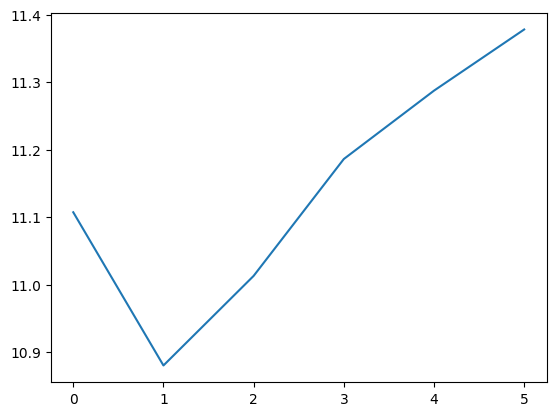

  6%|███████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 6/100 [1:41:36<26:00:19, 995.95s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a891d50>, test/blurry_pixcorr=0.47, test/loss=11.4, test/loss_clip_total=0.312, test/loss_prior=0.369, test/num_steps=6, test/test_bwd_pct_correct=0.896, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.709, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=9.08, train/loss_

[E6/100 I0/559]
  Loss 8.485569953918457
[E6/100 I50/559]
  Loss 7.719698429107666
[E6/100 I100/559]
  Loss 12.637579917907715
[E6/100 I150/559]
  Loss 8.774453163146973
[E6/100 I200/559]
  Loss 9.565714836120605
[E6/100 I250/559]
  Loss 7.644279479980469
[E6/100 I300/559]
  Loss 6.060423374176025
[E6/100 I350/559]
  Loss 7.696639060974121
[E6/100 I400/559]
  Loss 6.966797351837158
[E6/100 I450/559]
  Loss 8.489832878112793
[E6/100 I500/559]
  Loss 6.02533483505249
[E6/100 I550/559]
  Loss 8.371875762939453

---Evaluating---



  6%|███████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 6/100 [1:57:52<26:00:19, 995.95s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b496d50>, test/blurry_pixcorr=0.475, test/loss=11.6, test/loss_clip_total=0.306, test/loss_prior=0.377, test/num_steps=7, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.722, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.73, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 6 / 100


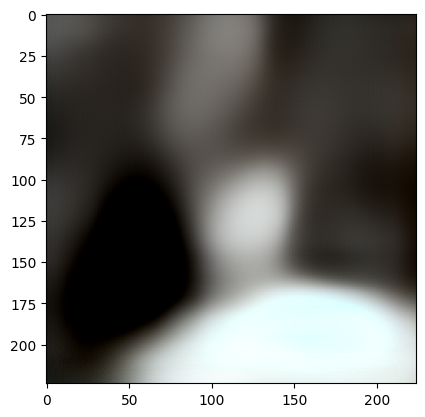

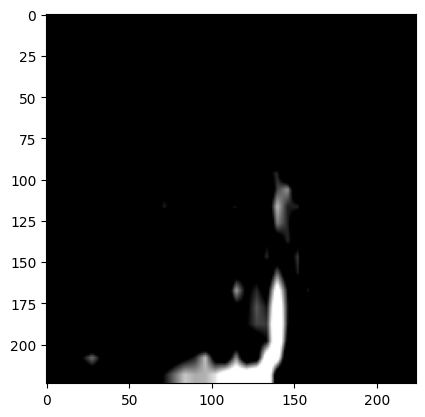

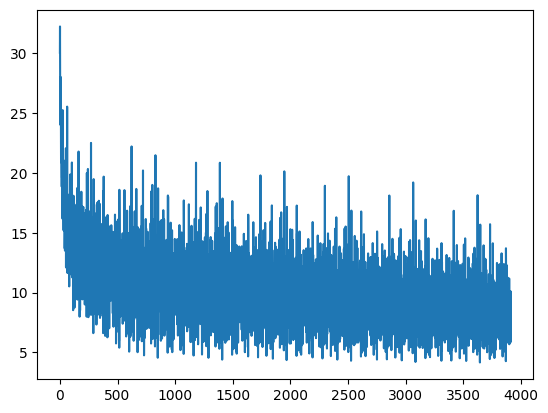

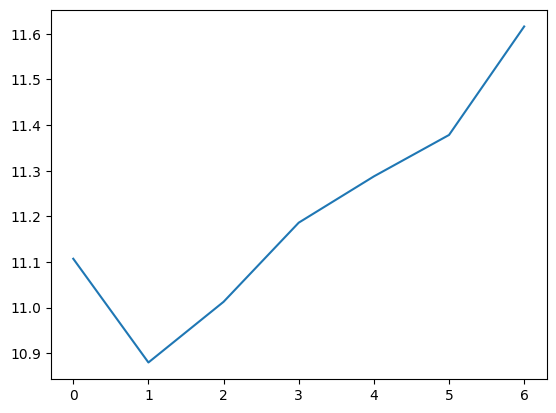

  7%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 7/100 [1:57:59<25:37:26, 991.90s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b496d50>, test/blurry_pixcorr=0.475, test/loss=11.6, test/loss_clip_total=0.306, test/loss_prior=0.377, test/num_steps=7, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.722, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.73, train/loss

[E7/100 I0/559]
  Loss 8.384454727172852
[E7/100 I50/559]
  Loss 7.484704971313477
[E7/100 I100/559]
  Loss 12.15534496307373
[E7/100 I150/559]
  Loss 8.350606918334961
[E7/100 I200/559]
  Loss 9.407821655273438
[E7/100 I250/559]
  Loss 7.429330825805664
[E7/100 I300/559]
  Loss 5.7474493980407715
[E7/100 I350/559]
  Loss 7.453381061553955
[E7/100 I400/559]
  Loss 6.771778583526611
[E7/100 I450/559]
  Loss 8.399179458618164
[E7/100 I500/559]
  Loss 5.902440547943115
[E7/100 I550/559]
  Loss 8.175920486450195

---Evaluating---



  7%|█████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 7/100 [2:14:13<25:37:26, 991.90s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b7df4d0>, test/blurry_pixcorr=0.469, test/loss=11.7, test/loss_clip_total=0.339, test/loss_prior=0.38, test/num_steps=8, test/test_bwd_pct_correct=0.904, test/test_fwd_pct_correct=0.902, train/blurry_pixcorr=0.736, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.4, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 7 / 100


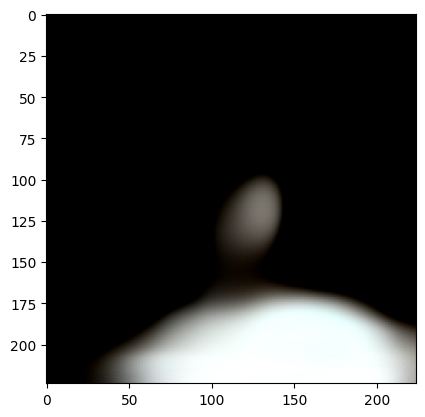

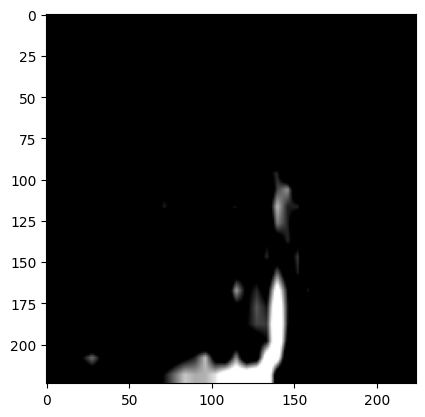

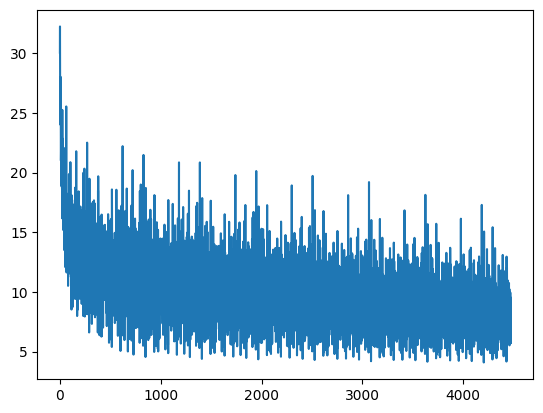

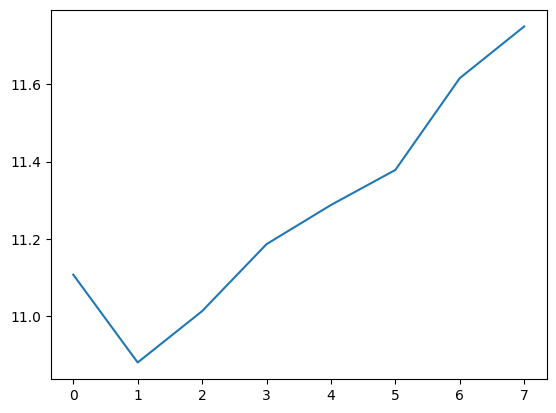

  8%|███████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 8/100 [2:14:20<25:15:31, 988.38s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b7df4d0>, test/blurry_pixcorr=0.469, test/loss=11.7, test/loss_clip_total=0.339, test/loss_prior=0.38, test/num_steps=8, test/test_bwd_pct_correct=0.904, test/test_fwd_pct_correct=0.902, train/blurry_pixcorr=0.736, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.4, train/loss_

[E8/100 I0/559]
  Loss 8.244462966918945
[E8/100 I50/559]
  Loss 7.100171089172363
[E8/100 I100/559]
  Loss 11.487800598144531
[E8/100 I150/559]
  Loss 7.903256416320801
[E8/100 I200/559]
  Loss 9.079440116882324
[E8/100 I250/559]
  Loss 6.975005149841309
[E8/100 I300/559]
  Loss 5.569275856018066
[E8/100 I350/559]
  Loss 7.226017951965332
[E8/100 I400/559]
  Loss 6.413035869598389
[E8/100 I450/559]
  Loss 8.21365737915039
[E8/100 I500/559]
  Loss 5.724344730377197
[E8/100 I550/559]
  Loss 8.040237426757812

---Evaluating---



  8%|███████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 8/100 [2:30:35<25:15:31, 988.38s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a3f6690>, test/blurry_pixcorr=0.47, test/loss=11.8, test/loss_clip_total=0.322, test/loss_prior=0.384, test/num_steps=9, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.908, train/blurry_pixcorr=0.75, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.09, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 8 / 100


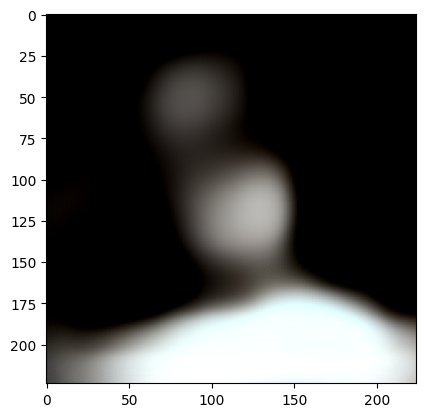

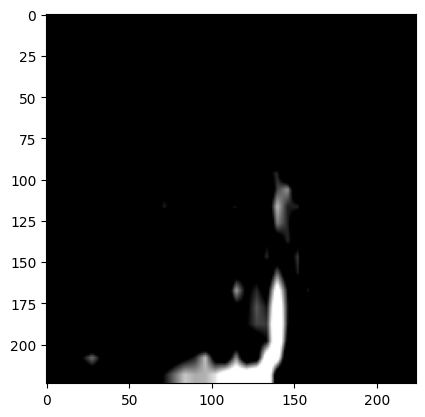

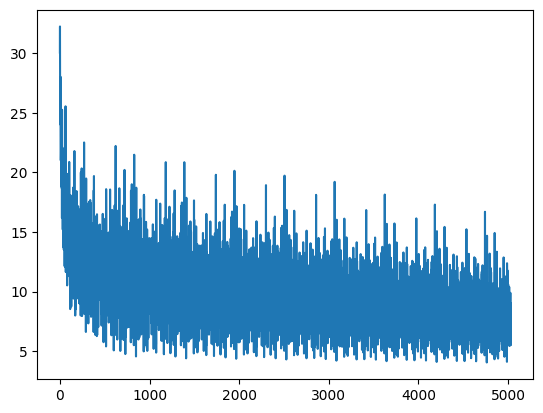

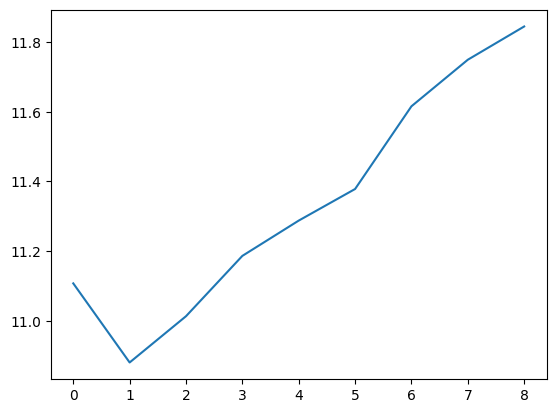

  9%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 9/100 [2:30:42<24:55:49, 986.26s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a3f6690>, test/blurry_pixcorr=0.47, test/loss=11.8, test/loss_clip_total=0.322, test/loss_prior=0.384, test/num_steps=9, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.908, train/blurry_pixcorr=0.75, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=8.09, train/loss_

[E9/100 I0/559]
  Loss 8.109075546264648
[E9/100 I50/559]
  Loss 6.844400882720947
[E9/100 I100/559]
  Loss 11.177300453186035
[E9/100 I150/559]
  Loss 7.514612197875977
[E9/100 I200/559]
  Loss 8.895610809326172
[E9/100 I250/559]
  Loss 6.678952217102051
[E9/100 I300/559]
  Loss 5.403017044067383
[E9/100 I350/559]
  Loss 6.902066707611084
[E9/100 I400/559]
  Loss 6.312565326690674
[E9/100 I450/559]
  Loss 8.073406219482422
[E9/100 I500/559]
  Loss 5.654928684234619
[E9/100 I550/559]
  Loss 7.850306987762451

---Evaluating---



  9%|█████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 9/100 [2:46:58<24:55:49, 986.26s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a404550>, test/blurry_pixcorr=0.468, test/loss=11.9, test/loss_clip_total=0.322, test/loss_prior=0.387, test/num_steps=10, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.76, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.8, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/ep9 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 9 / 100


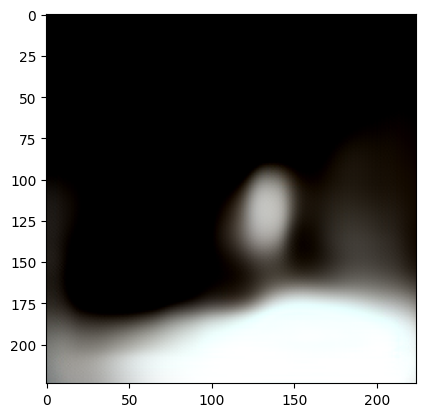

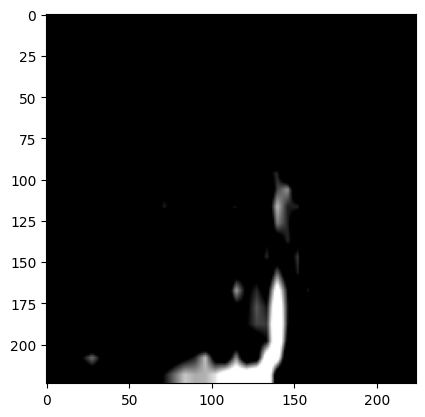

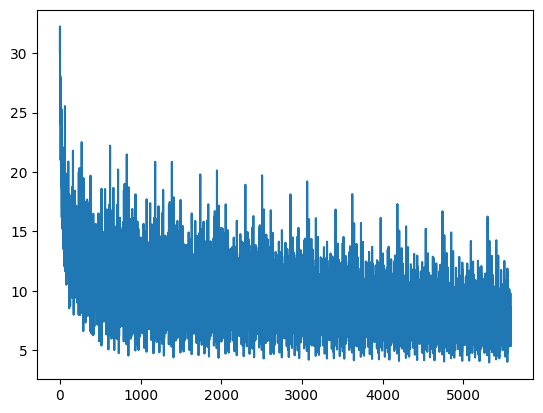

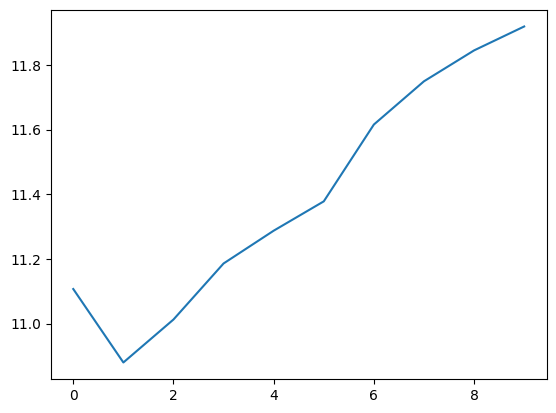

 10%|███████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 10/100 [2:47:11<24:40:50, 987.23s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a404550>, test/blurry_pixcorr=0.468, test/loss=11.9, test/loss_clip_total=0.322, test/loss_prior=0.387, test/num_steps=10, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.76, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.8, train/loss_

[E10/100 I0/559]
  Loss 8.053841590881348
[E10/100 I50/559]
  Loss 6.649260997772217
[E10/100 I100/559]
  Loss 10.928669929504395
[E10/100 I150/559]
  Loss 7.251593589782715
[E10/100 I200/559]
  Loss 8.829777717590332
[E10/100 I250/559]
  Loss 6.497459411621094
[E10/100 I300/559]
  Loss 5.305772304534912
[E10/100 I350/559]
  Loss 6.609760284423828
[E10/100 I400/559]
  Loss 5.992222785949707
[E10/100 I450/559]
  Loss 7.9538254737854
[E10/100 I500/559]
  Loss 5.3003387451171875
[E10/100 I550/559]
  Loss 7.713391304016113

---Evaluating---



 10%|███████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 10/100 [3:03:27<24:40:50, 987.23s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b429b10>, test/blurry_pixcorr=0.471, test/loss=12, test/loss_clip_total=0.314, test/loss_prior=0.389, test/num_steps=11, test/test_bwd_pct_correct=0.9, test/test_fwd_pct_correct=0.912, train/blurry_pixcorr=0.773, train/bwd_pct_correct=0.999, train/fwd_pct_correct=1, train/loss=7.54, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 10 / 100


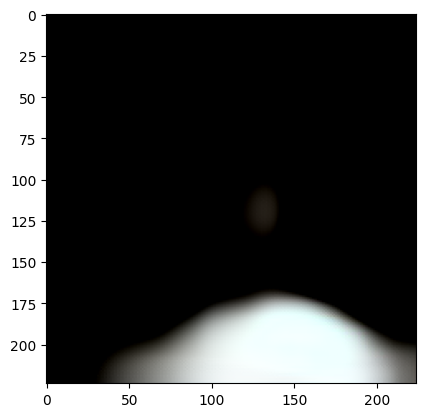

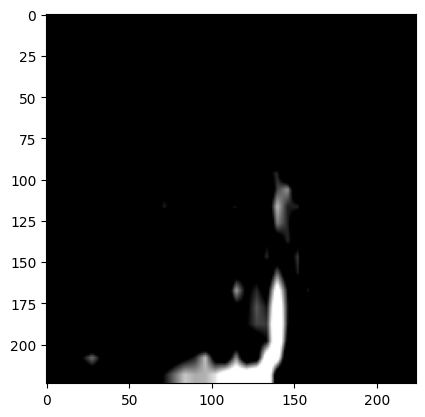

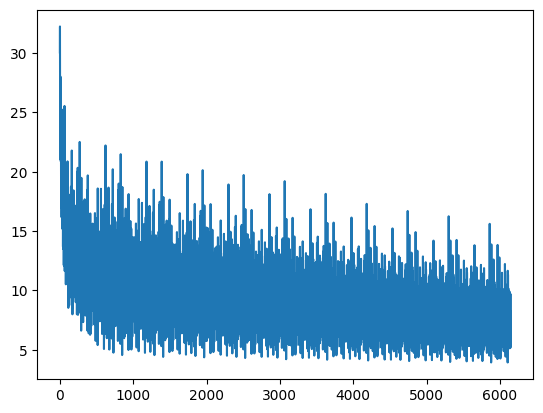

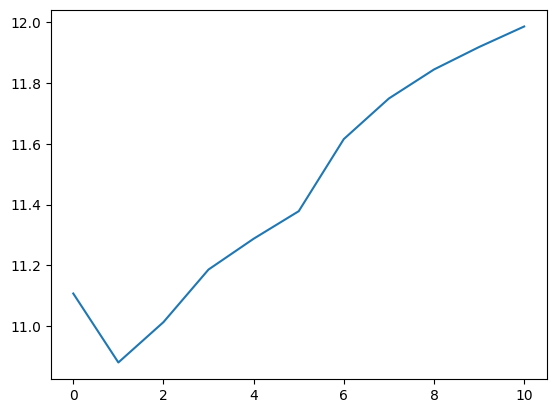

 11%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 11/100 [3:03:33<24:22:09, 985.72s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b429b10>, test/blurry_pixcorr=0.471, test/loss=12, test/loss_clip_total=0.314, test/loss_prior=0.389, test/num_steps=11, test/test_bwd_pct_correct=0.9, test/test_fwd_pct_correct=0.912, train/blurry_pixcorr=0.773, train/bwd_pct_correct=0.999, train/fwd_pct_correct=1, train/loss=7.54, train/loss

[E11/100 I0/559]
  Loss 7.916625022888184
[E11/100 I50/559]
  Loss 6.421423435211182
[E11/100 I100/559]
  Loss 10.552082061767578
[E11/100 I150/559]
  Loss 6.8391547203063965
[E11/100 I200/559]
  Loss 8.551630020141602
[E11/100 I250/559]
  Loss 6.366781234741211
[E11/100 I300/559]
  Loss 5.1596598625183105
[E11/100 I350/559]
  Loss 6.5077314376831055
[E11/100 I400/559]
  Loss 5.84634256362915
[E11/100 I450/559]
  Loss 7.777126789093018
[E11/100 I500/559]
  Loss 5.207162380218506
[E11/100 I550/559]
  Loss 7.557194709777832

---Evaluating---



 11%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 11/100 [3:19:49<24:22:09, 985.72s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a5c2b90>, test/blurry_pixcorr=0.468, test/loss=12.1, test/loss_clip_total=0.315, test/loss_prior=0.394, test/num_steps=12, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.91, train/blurry_pixcorr=0.784, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.31, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 11 / 100


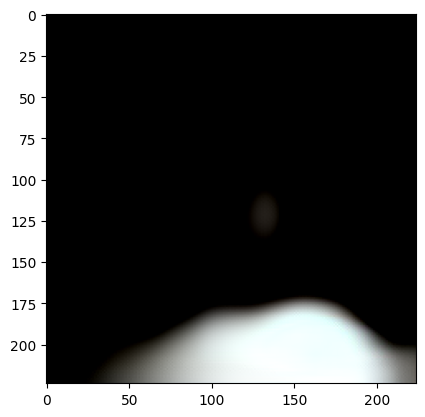

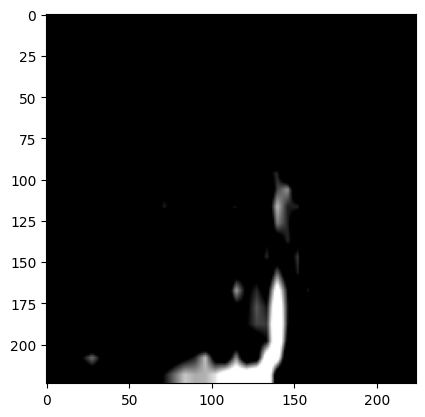

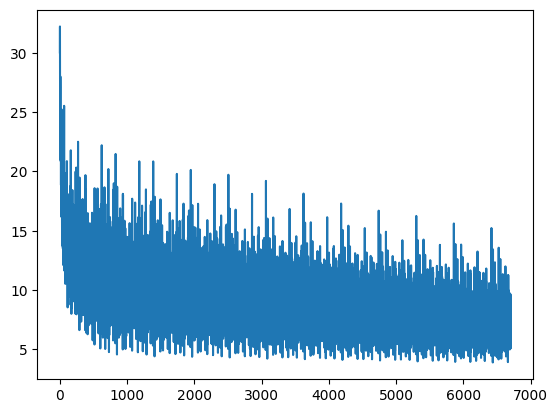

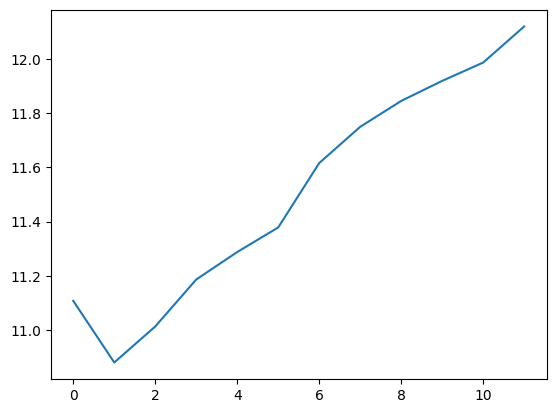

 12%|███████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 12/100 [3:19:56<24:04:23, 984.81s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a5c2b90>, test/blurry_pixcorr=0.468, test/loss=12.1, test/loss_clip_total=0.315, test/loss_prior=0.394, test/num_steps=12, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.91, train/blurry_pixcorr=0.784, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.31, train/loss_

[E12/100 I0/559]
  Loss 7.850279331207275
[E12/100 I50/559]
  Loss 6.38466215133667
[E12/100 I100/559]
  Loss 10.184591293334961
[E12/100 I150/559]
  Loss 6.677720546722412
[E12/100 I200/559]
  Loss 8.427080154418945
[E12/100 I250/559]
  Loss 6.223852634429932
[E12/100 I300/559]
  Loss 5.0810136795043945
[E12/100 I350/559]
  Loss 6.264408111572266
[E12/100 I400/559]
  Loss 5.805704593658447
[E12/100 I450/559]
  Loss 7.6883769035339355
[E12/100 I500/559]
  Loss 5.076029300689697
[E12/100 I550/559]
  Loss 7.456835746765137

---Evaluating---



 12%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 12/100 [3:36:12<24:04:23, 984.81s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b707710>, test/blurry_pixcorr=0.47, test/loss=12.1, test/loss_clip_total=0.297, test/loss_prior=0.395, test/num_steps=13, test/test_bwd_pct_correct=0.9, test/test_fwd_pct_correct=0.915, train/blurry_pixcorr=0.794, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.12, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 12 / 100


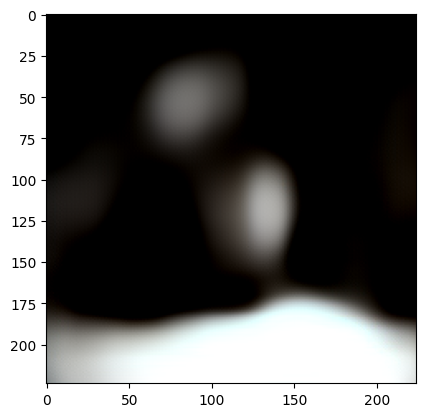

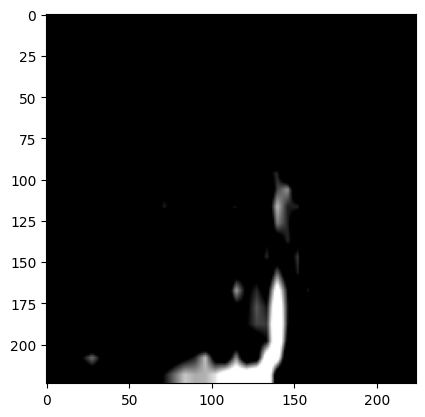

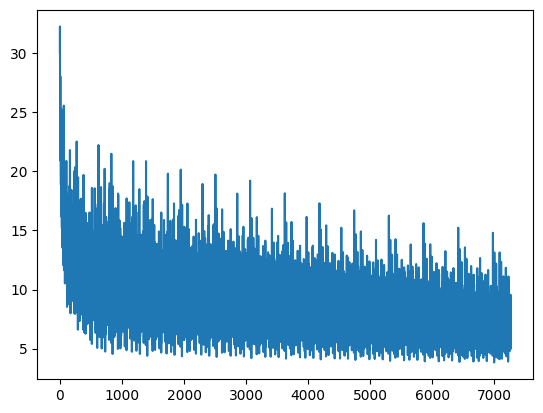

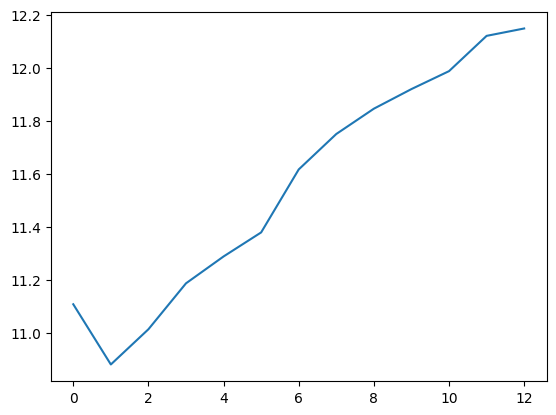

 13%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 13/100 [3:36:19<23:47:05, 984.21s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b707710>, test/blurry_pixcorr=0.47, test/loss=12.1, test/loss_clip_total=0.297, test/loss_prior=0.395, test/num_steps=13, test/test_bwd_pct_correct=0.9, test/test_fwd_pct_correct=0.915, train/blurry_pixcorr=0.794, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=7.12, train/loss_

[E13/100 I0/559]
  Loss 7.812255859375
[E13/100 I50/559]
  Loss 6.078178405761719
[E13/100 I100/559]
  Loss 9.888364791870117
[E13/100 I150/559]
  Loss 6.450360298156738
[E13/100 I200/559]
  Loss 8.193957328796387
[E13/100 I250/559]
  Loss 6.120108604431152
[E13/100 I300/559]
  Loss 5.00565767288208
[E13/100 I350/559]
  Loss 6.16470193862915
[E13/100 I400/559]
  Loss 5.610621452331543
[E13/100 I450/559]
  Loss 7.578646659851074
[E13/100 I500/559]
  Loss 5.0001606941223145
[E13/100 I550/559]
  Loss 7.347433090209961

---Evaluating---



 13%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 13/100 [3:52:35<23:47:05, 984.21s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b6b84d0>, test/blurry_pixcorr=0.466, test/loss=12.3, test/loss_clip_total=0.305, test/loss_prior=0.399, test/num_steps=14, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.913, train/blurry_pixcorr=0.805, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.94, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 13 / 100


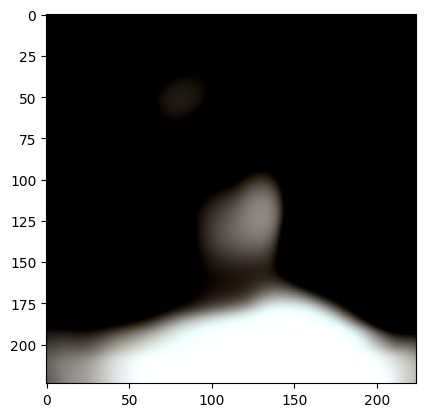

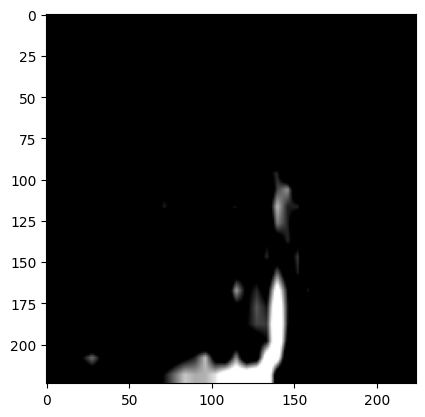

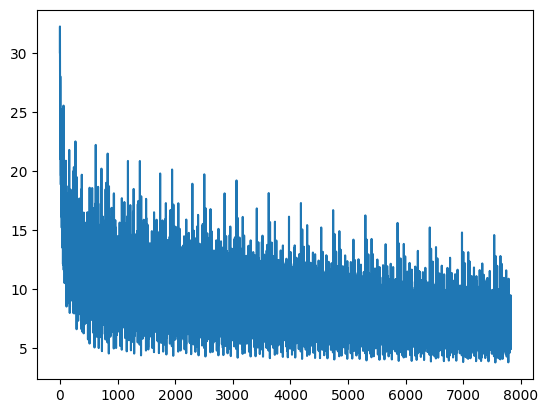

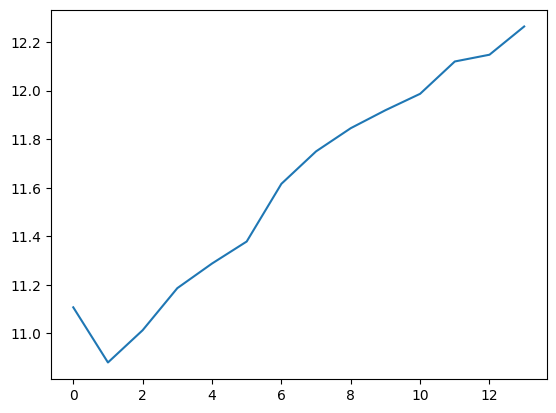

 14%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 14/100 [3:52:42<23:30:01, 983.74s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b6b84d0>, test/blurry_pixcorr=0.466, test/loss=12.3, test/loss_clip_total=0.305, test/loss_prior=0.399, test/num_steps=14, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.913, train/blurry_pixcorr=0.805, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.94, train/loss_

[E14/100 I0/559]
  Loss 7.760875225067139
[E14/100 I50/559]
  Loss 5.859943389892578
[E14/100 I100/559]
  Loss 9.614899635314941
[E14/100 I150/559]
  Loss 6.224536895751953
[E14/100 I200/559]
  Loss 8.034612655639648
[E14/100 I250/559]
  Loss 6.015564441680908
[E14/100 I300/559]
  Loss 4.9474310874938965
[E14/100 I350/559]
  Loss 6.105524063110352
[E14/100 I400/559]
  Loss 5.480072021484375
[E14/100 I450/559]
  Loss 7.535217761993408
[E14/100 I500/559]
  Loss 4.855068683624268
[E14/100 I550/559]
  Loss 7.255687713623047

---Evaluating---



 14%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 14/100 [4:08:57<23:30:01, 983.74s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a6fd790>, test/blurry_pixcorr=0.465, test/loss=12.3, test/loss_clip_total=0.305, test/loss_prior=0.4, test/num_steps=15, test/test_bwd_pct_correct=0.894, test/test_fwd_pct_correct=0.913, train/blurry_pixcorr=0.811, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.79, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/ep14 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 14 / 100


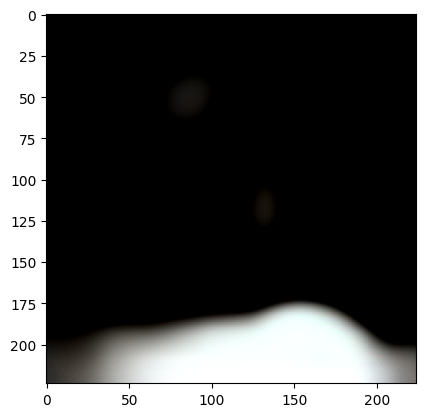

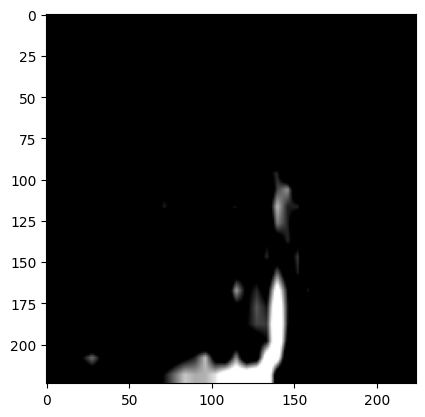

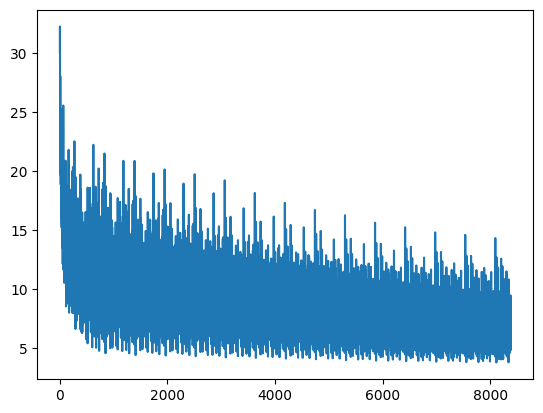

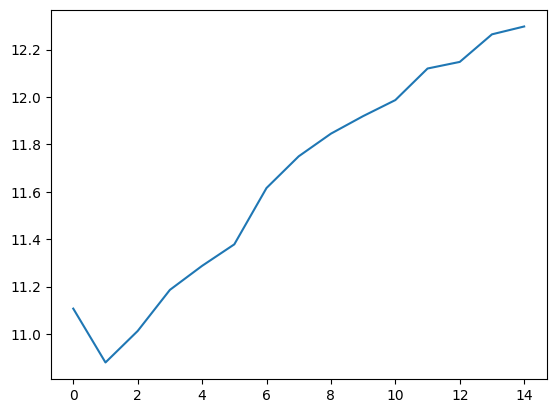

 15%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 15/100 [4:09:12<23:16:30, 985.77s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a6fd790>, test/blurry_pixcorr=0.465, test/loss=12.3, test/loss_clip_total=0.305, test/loss_prior=0.4, test/num_steps=15, test/test_bwd_pct_correct=0.894, test/test_fwd_pct_correct=0.913, train/blurry_pixcorr=0.811, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.79, train/loss_

[E15/100 I0/559]
  Loss 7.724978446960449
[E15/100 I50/559]
  Loss 5.681386470794678
[E15/100 I100/559]
  Loss 9.277702331542969
[E15/100 I150/559]
  Loss 5.949901103973389
[E15/100 I200/559]
  Loss 7.8187713623046875
[E15/100 I250/559]
  Loss 5.768693447113037
[E15/100 I300/559]
  Loss 4.847440719604492
[E15/100 I350/559]
  Loss 5.945038318634033
[E15/100 I400/559]
  Loss 5.4376630783081055
[E15/100 I450/559]
  Loss 7.419593811035156
[E15/100 I500/559]
  Loss 4.720900535583496
[E15/100 I550/559]
  Loss 7.188516139984131

---Evaluating---



 15%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 15/100 [4:25:28<23:16:30, 985.77s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0e8083dad0>, test/blurry_pixcorr=0.466, test/loss=12.5, test/loss_clip_total=0.317, test/loss_prior=0.406, test/num_steps=16, test/test_bwd_pct_correct=0.892, test/test_fwd_pct_correct=0.91, train/blurry_pixcorr=0.82, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.64, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 15 / 100


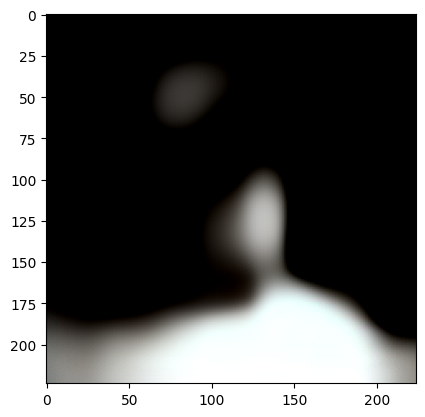

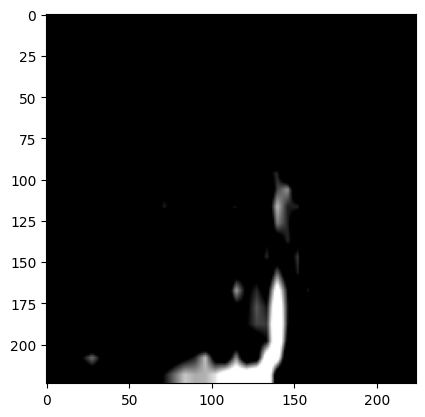

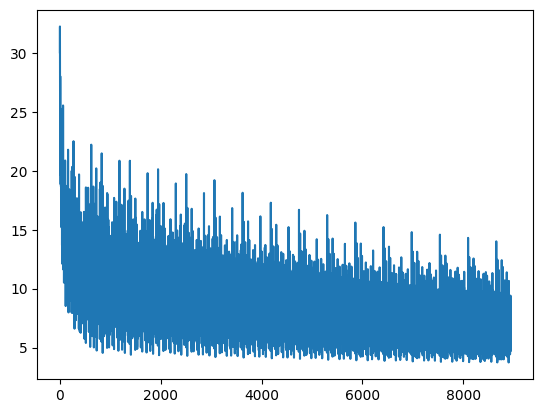

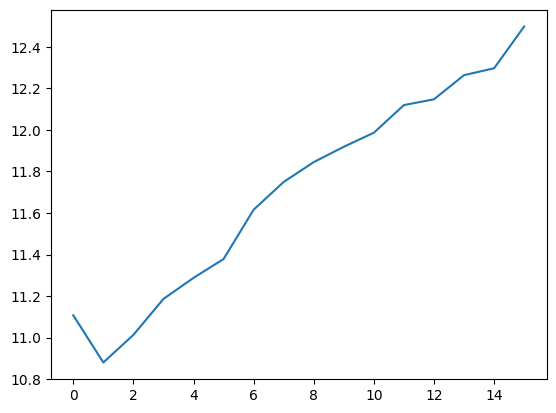

 16%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 16/100 [4:25:35<22:58:49, 984.87s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0e8083dad0>, test/blurry_pixcorr=0.466, test/loss=12.5, test/loss_clip_total=0.317, test/loss_prior=0.406, test/num_steps=16, test/test_bwd_pct_correct=0.892, test/test_fwd_pct_correct=0.91, train/blurry_pixcorr=0.82, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.64, train/loss

[E16/100 I0/559]
  Loss 7.670049667358398
[E16/100 I50/559]
  Loss 5.623106479644775
[E16/100 I100/559]
  Loss 9.158676147460938
[E16/100 I150/559]
  Loss 5.889920234680176
[E16/100 I200/559]
  Loss 7.803378582000732
[E16/100 I250/559]
  Loss 5.638676643371582
[E16/100 I300/559]
  Loss 4.829878330230713
[E16/100 I350/559]
  Loss 5.766316890716553
[E16/100 I400/559]
  Loss 5.275652885437012
[E16/100 I450/559]
  Loss 7.314128875732422
[E16/100 I500/559]
  Loss 4.6393914222717285
[E16/100 I550/559]
  Loss 7.099404811859131

---Evaluating---



 16%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 16/100 [4:41:50<22:58:49, 984.87s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2ab12210>, test/blurry_pixcorr=0.467, test/loss=12.5, test/loss_clip_total=0.304, test/loss_prior=0.407, test/num_steps=17, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.923, train/blurry_pixcorr=0.825, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.52, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 16 / 100


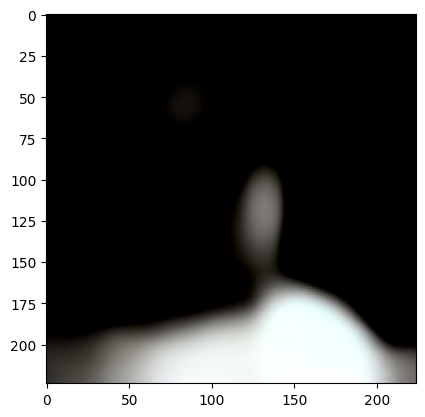

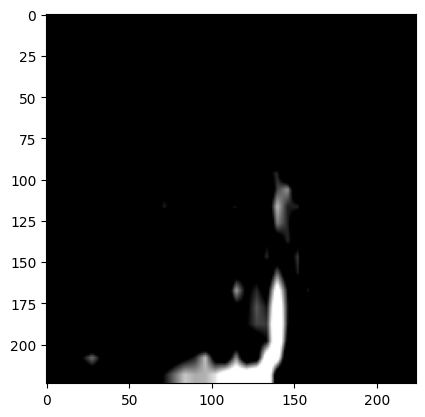

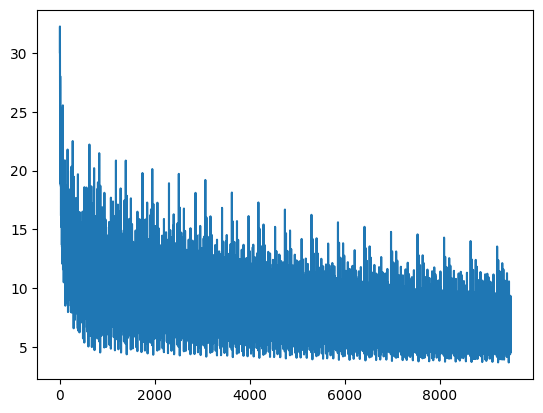

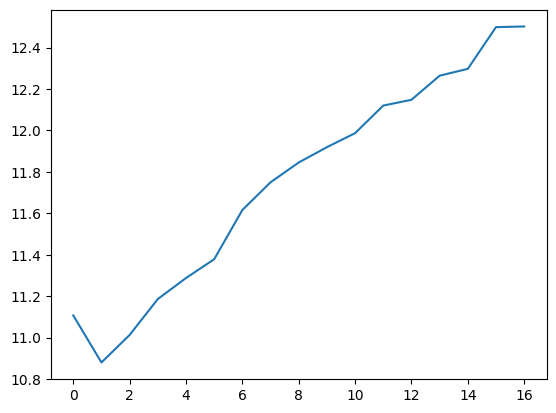

 17%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 17/100 [4:41:57<22:41:04, 983.91s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2ab12210>, test/blurry_pixcorr=0.467, test/loss=12.5, test/loss_clip_total=0.304, test/loss_prior=0.407, test/num_steps=17, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.923, train/blurry_pixcorr=0.825, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.52, train/loss_

[E17/100 I0/559]
  Loss 7.608288764953613
[E17/100 I50/559]
  Loss 5.492823123931885
[E17/100 I100/559]
  Loss 8.911483764648438
[E17/100 I150/559]
  Loss 5.766346454620361
[E17/100 I200/559]
  Loss 7.690380096435547
[E17/100 I250/559]
  Loss 5.586508274078369
[E17/100 I300/559]
  Loss 4.768946170806885
[E17/100 I350/559]
  Loss 5.698969841003418
[E17/100 I400/559]
  Loss 5.205835819244385
[E17/100 I450/559]
  Loss 7.265972137451172
[E17/100 I500/559]
  Loss 4.565713405609131
[E17/100 I550/559]
  Loss 6.96998405456543

---Evaluating---



 17%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 17/100 [4:58:11<22:41:04, 983.91s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a322ed0>, test/blurry_pixcorr=0.464, test/loss=12.5, test/loss_clip_total=0.307, test/loss_prior=0.405, test/num_steps=18, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.927, train/blurry_pixcorr=0.833, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.39, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 17 / 100


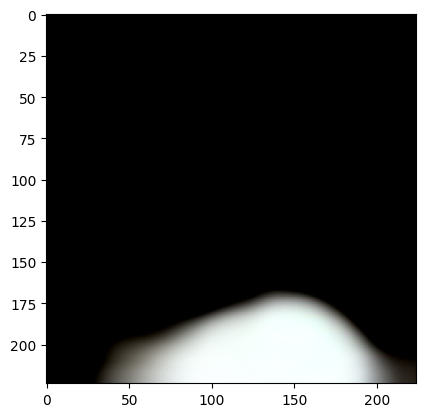

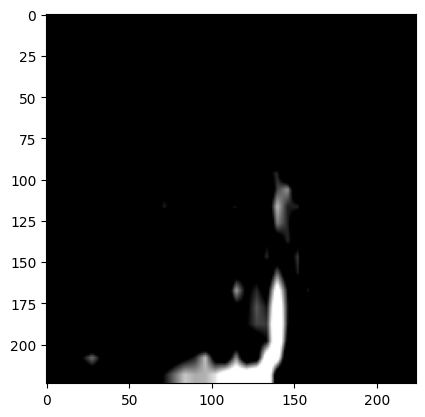

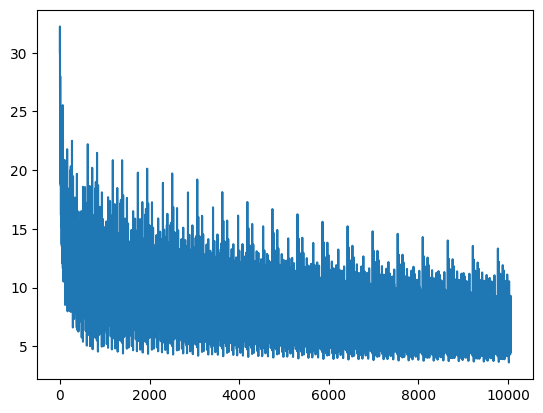

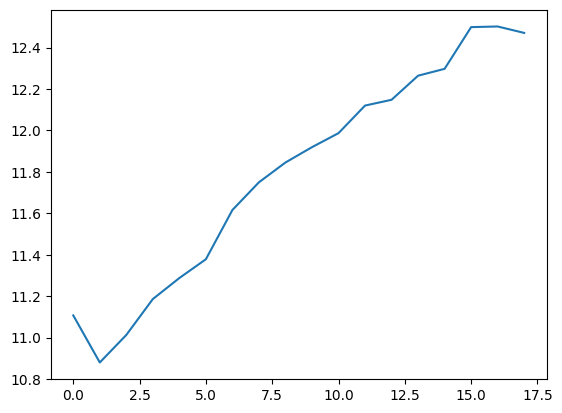

 18%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 18/100 [4:58:18<22:23:29, 983.04s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a322ed0>, test/blurry_pixcorr=0.464, test/loss=12.5, test/loss_clip_total=0.307, test/loss_prior=0.405, test/num_steps=18, test/test_bwd_pct_correct=0.89, test/test_fwd_pct_correct=0.927, train/blurry_pixcorr=0.833, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.39, train/loss_

[E18/100 I0/559]
  Loss 7.523853302001953
[E18/100 I50/559]
  Loss 5.415751934051514
[E18/100 I100/559]
  Loss 8.88713264465332
[E18/100 I150/559]
  Loss 5.701844215393066
[E18/100 I200/559]
  Loss 7.641971588134766
[E18/100 I250/559]
  Loss 5.463504791259766
[E18/100 I300/559]
  Loss 4.704629898071289
[E18/100 I350/559]
  Loss 5.594842433929443
[E18/100 I400/559]
  Loss 5.141036510467529
[E18/100 I450/559]
  Loss 7.265488624572754
[E18/100 I500/559]
  Loss 4.539184093475342
[E18/100 I550/559]
  Loss 6.949450492858887

---Evaluating---



 18%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 18/100 [5:14:33<22:23:29, 983.04s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0b745bc590>, test/blurry_pixcorr=0.466, test/loss=12.6, test/loss_clip_total=0.311, test/loss_prior=0.411, test/num_steps=19, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.837, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.28, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 18 / 100


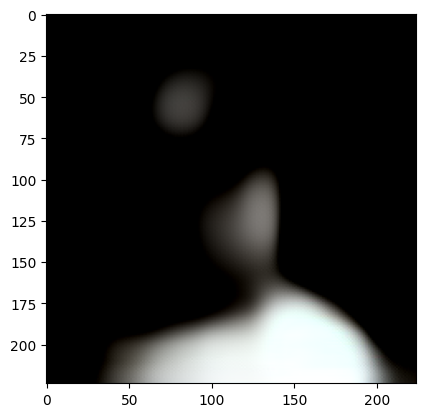

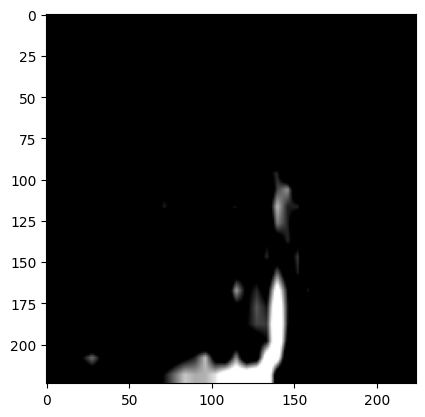

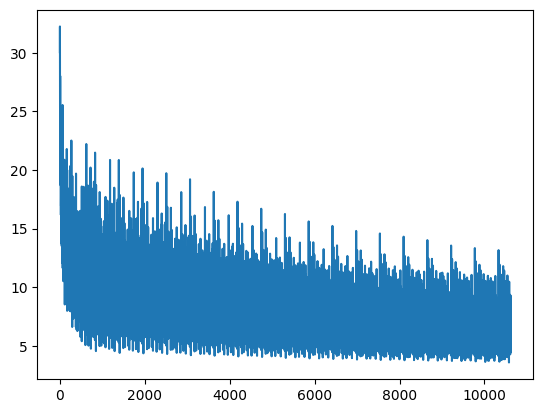

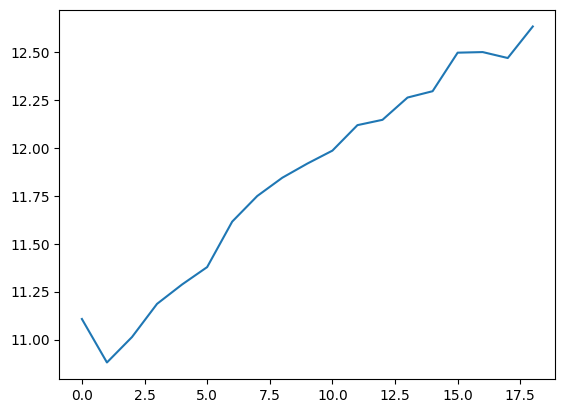

 19%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 19/100 [5:14:40<22:06:56, 982.92s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0b745bc590>, test/blurry_pixcorr=0.466, test/loss=12.6, test/loss_clip_total=0.311, test/loss_prior=0.411, test/num_steps=19, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.837, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.28, train/loss_b

[E19/100 I0/559]
  Loss 7.499481678009033
[E19/100 I50/559]
  Loss 5.290136337280273
[E19/100 I100/559]
  Loss 8.751044273376465
[E19/100 I150/559]
  Loss 5.661596298217773
[E19/100 I200/559]
  Loss 7.514089107513428
[E19/100 I250/559]
  Loss 5.3263115882873535
[E19/100 I300/559]
  Loss 4.592713832855225
[E19/100 I350/559]
  Loss 5.522627830505371
[E19/100 I400/559]
  Loss 5.0361151695251465
[E19/100 I450/559]
  Loss 7.198811054229736
[E19/100 I500/559]
  Loss 4.443544387817383
[E19/100 I550/559]
  Loss 6.884581565856934

---Evaluating---



 19%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 19/100 [5:30:56<22:06:56, 982.92s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a79dd10>, test/blurry_pixcorr=0.466, test/loss=12.4, test/loss_clip_total=0.308, test/loss_prior=0.404, test/num_steps=20, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.917, train/blurry_pixcorr=0.845, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.19, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/ep19 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 19 / 100


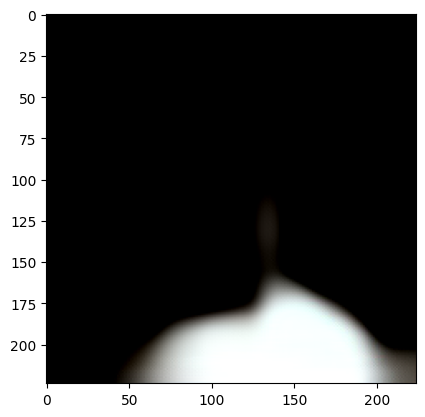

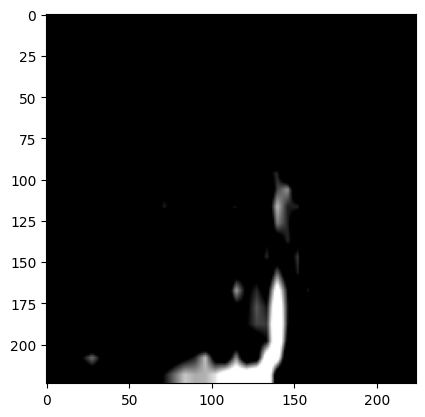

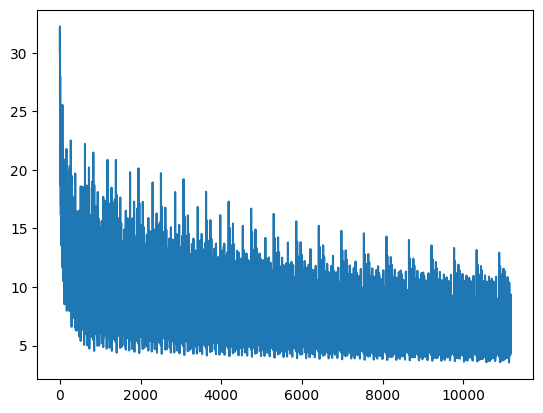

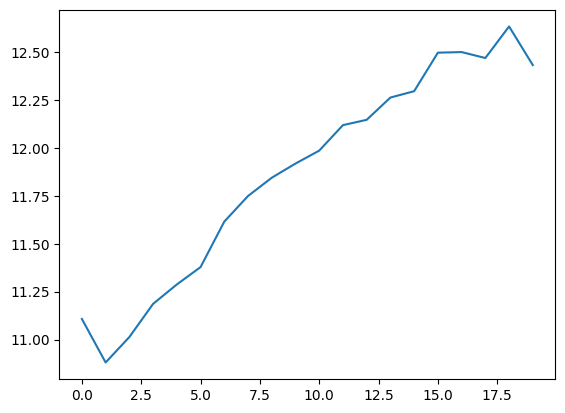

 20%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 20/100 [5:31:09<21:52:53, 984.67s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a79dd10>, test/blurry_pixcorr=0.466, test/loss=12.4, test/loss_clip_total=0.308, test/loss_prior=0.404, test/num_steps=20, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.917, train/blurry_pixcorr=0.845, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.19, train/loss_b

[E20/100 I0/559]
  Loss 7.454658031463623
[E20/100 I50/559]
  Loss 5.170409679412842
[E20/100 I100/559]
  Loss 8.652678489685059
[E20/100 I150/559]
  Loss 5.550531387329102
[E20/100 I200/559]
  Loss 7.423379421234131
[E20/100 I250/559]
  Loss 5.207893371582031
[E20/100 I300/559]
  Loss 4.494405746459961
[E20/100 I350/559]
  Loss 5.416126728057861
[E20/100 I400/559]
  Loss 5.009372234344482
[E20/100 I450/559]
  Loss 7.125331878662109
[E20/100 I500/559]
  Loss 4.297237396240234
[E20/100 I550/559]
  Loss 6.805578231811523

---Evaluating---



 20%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 20/100 [5:47:25<21:52:53, 984.67s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b754f10>, test/blurry_pixcorr=0.468, test/loss=12.6, test/loss_clip_total=0.314, test/loss_prior=0.409, test/num_steps=21, test/test_bwd_pct_correct=0.879, test/test_fwd_pct_correct=0.917, train/blurry_pixcorr=0.85, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.1, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 20 / 100


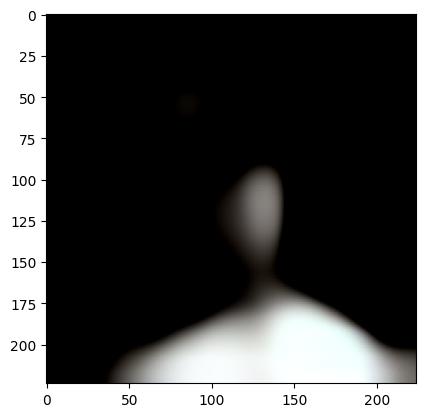

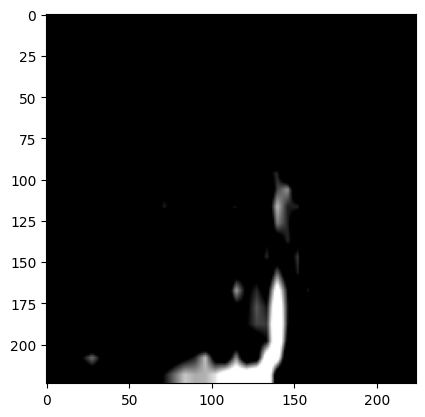

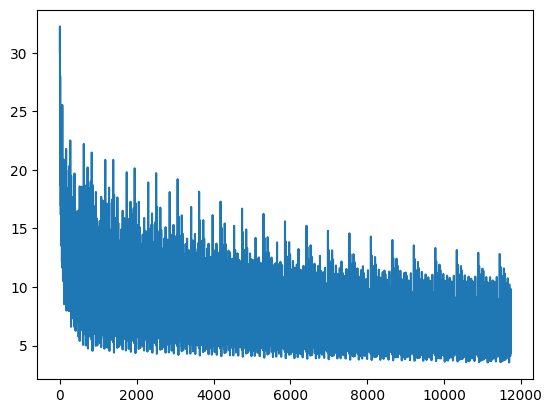

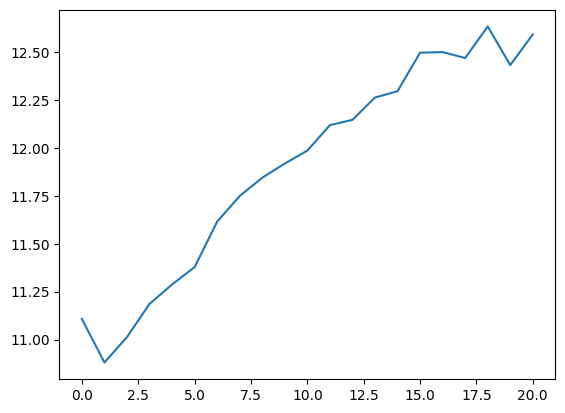

 21%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 21/100 [5:47:32<21:35:40, 984.06s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b754f10>, test/blurry_pixcorr=0.468, test/loss=12.6, test/loss_clip_total=0.314, test/loss_prior=0.409, test/num_steps=21, test/test_bwd_pct_correct=0.879, test/test_fwd_pct_correct=0.917, train/blurry_pixcorr=0.85, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.1, train/loss_b

[E21/100 I0/559]
  Loss 7.403473377227783
[E21/100 I50/559]
  Loss 5.127617359161377
[E21/100 I100/559]
  Loss 8.481099128723145
[E21/100 I150/559]
  Loss 5.445812702178955
[E21/100 I200/559]
  Loss 7.3322625160217285
[E21/100 I250/559]
  Loss 5.160508155822754
[E21/100 I300/559]
  Loss 4.469310283660889
[E21/100 I350/559]
  Loss 5.383440017700195
[E21/100 I400/559]
  Loss 4.9774699211120605
[E21/100 I450/559]
  Loss 7.076780796051025
[E21/100 I500/559]
  Loss 4.175297737121582
[E21/100 I550/559]
  Loss 6.766213893890381

---Evaluating---



 21%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 21/100 [6:03:48<21:35:40, 984.06s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a8d7090>, test/blurry_pixcorr=0.466, test/loss=12.7, test/loss_clip_total=0.299, test/loss_prior=0.413, test/num_steps=22, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.925, train/blurry_pixcorr=0.854, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.01, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 21 / 100


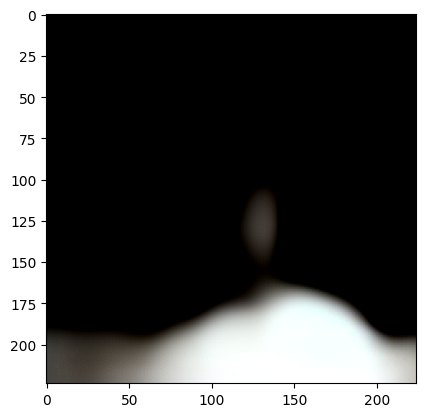

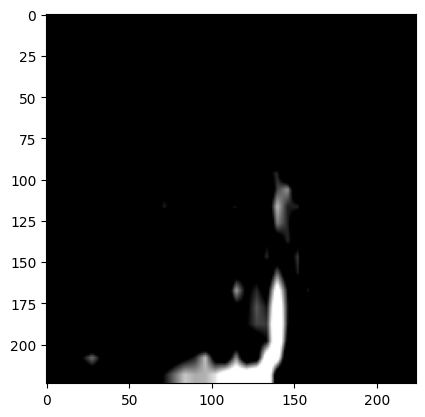

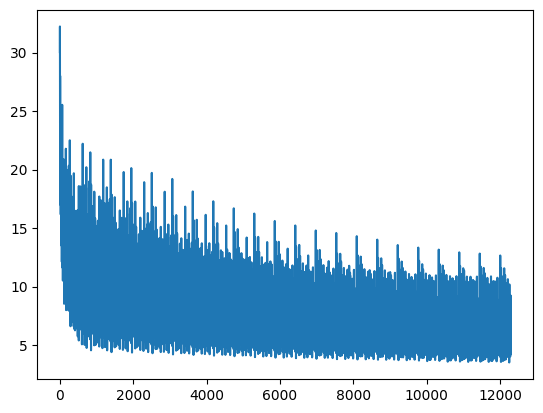

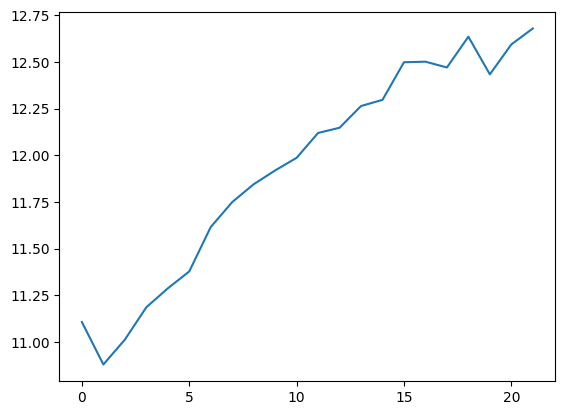

 22%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 22/100 [6:03:55<21:18:53, 983.76s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a8d7090>, test/blurry_pixcorr=0.466, test/loss=12.7, test/loss_clip_total=0.299, test/loss_prior=0.413, test/num_steps=22, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.925, train/blurry_pixcorr=0.854, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=6.01, train/loss_

[E22/100 I0/559]
  Loss 7.393505096435547
[E22/100 I50/559]
  Loss 5.082847595214844
[E22/100 I100/559]
  Loss 8.373316764831543
[E22/100 I150/559]
  Loss 5.357280731201172
[E22/100 I200/559]
  Loss 7.347696781158447
[E22/100 I250/559]
  Loss 5.070586681365967
[E22/100 I300/559]
  Loss 4.417696952819824
[E22/100 I350/559]
  Loss 5.3203630447387695
[E22/100 I400/559]
  Loss 4.8588056564331055
[E22/100 I450/559]
  Loss 7.0249505043029785
[E22/100 I500/559]
  Loss 4.154319763183594
[E22/100 I550/559]
  Loss 6.689330577850342

---Evaluating---



 22%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 22/100 [6:20:10<21:18:53, 983.76s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0b74666b50>, test/blurry_pixcorr=0.463, test/loss=12.7, test/loss_clip_total=0.307, test/loss_prior=0.412, test/num_steps=23, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.927, train/blurry_pixcorr=0.859, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.93, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 22 / 100


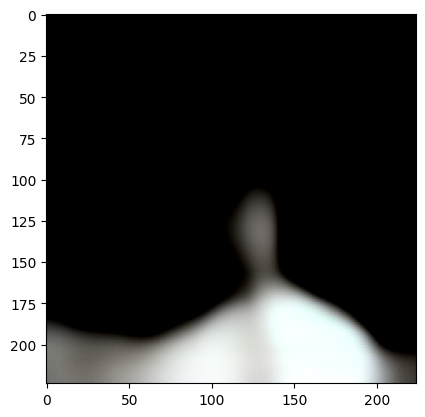

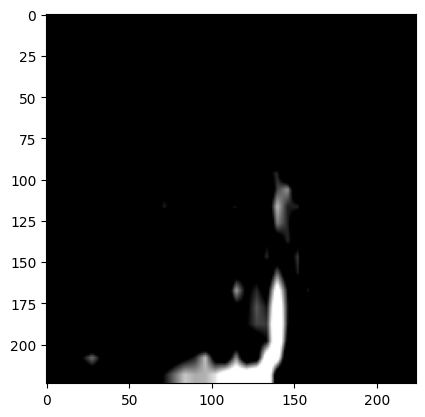

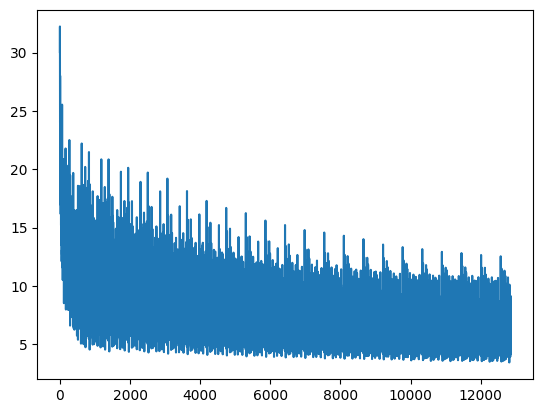

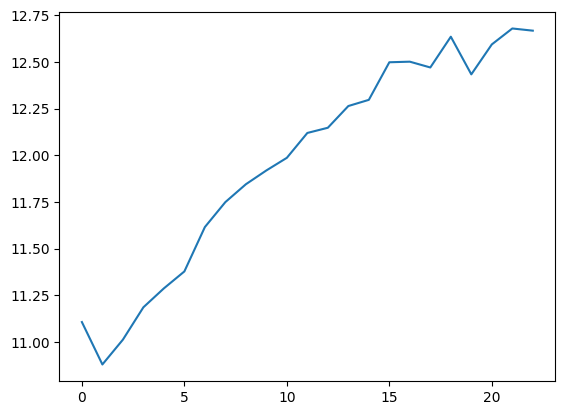

 23%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 23/100 [6:20:17<21:01:51, 983.27s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0b74666b50>, test/blurry_pixcorr=0.463, test/loss=12.7, test/loss_clip_total=0.307, test/loss_prior=0.412, test/num_steps=23, test/test_bwd_pct_correct=0.898, test/test_fwd_pct_correct=0.927, train/blurry_pixcorr=0.859, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.93, train/los

[E23/100 I0/559]
  Loss 7.325850009918213
[E23/100 I50/559]
  Loss 5.077535629272461
[E23/100 I100/559]
  Loss 8.244646072387695
[E23/100 I150/559]
  Loss 5.2963972091674805
[E23/100 I200/559]
  Loss 7.270259857177734
[E23/100 I250/559]
  Loss 5.015603065490723
[E23/100 I300/559]
  Loss 4.426227569580078
[E23/100 I350/559]
  Loss 5.212409019470215
[E23/100 I400/559]
  Loss 4.833709716796875
[E23/100 I450/559]
  Loss 6.984948635101318
[E23/100 I500/559]
  Loss 4.13638162612915
[E23/100 I550/559]
  Loss 6.653189659118652

---Evaluating---



 23%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 23/100 [6:36:33<21:01:51, 983.27s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a5421d0>, test/blurry_pixcorr=0.463, test/loss=13, test/loss_clip_total=0.614, test/loss_prior=0.412, test/num_steps=24, test/test_bwd_pct_correct=0.798, test/test_fwd_pct_correct=0.844, train/blurry_pixcorr=0.865, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.85, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 23 / 100


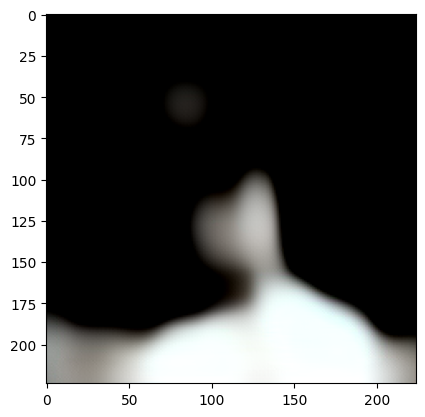

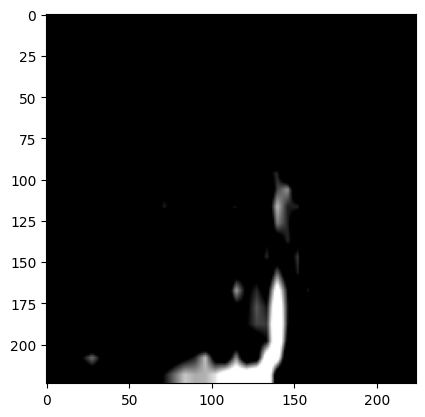

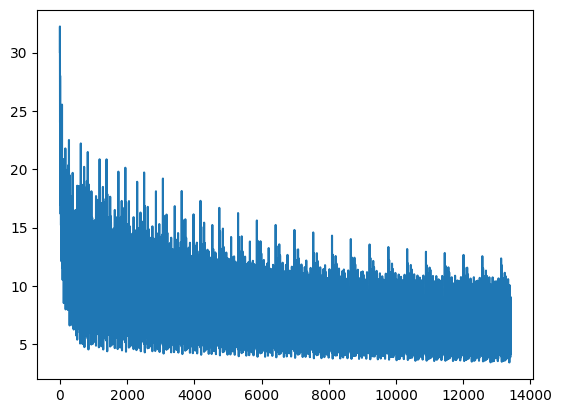

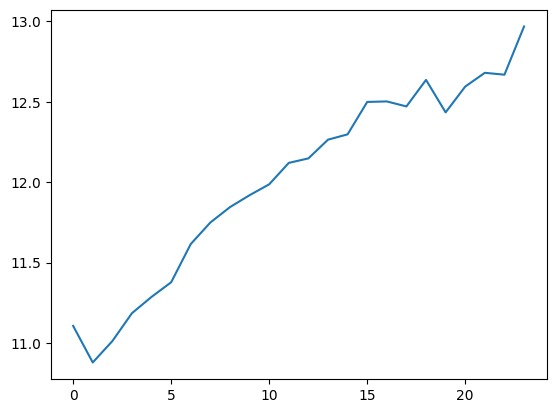

 24%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 24/100 [6:36:40<20:45:17, 983.12s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a5421d0>, test/blurry_pixcorr=0.463, test/loss=13, test/loss_clip_total=0.614, test/loss_prior=0.412, test/num_steps=24, test/test_bwd_pct_correct=0.798, test/test_fwd_pct_correct=0.844, train/blurry_pixcorr=0.865, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.85, train/loss_b

[E24/100 I0/559]
  Loss 7.367578029632568
[E24/100 I50/559]
  Loss 4.9072465896606445
[E24/100 I100/559]
  Loss 8.057822227478027
[E24/100 I150/559]
  Loss 5.1306867599487305
[E24/100 I200/559]
  Loss 7.212918281555176
[E24/100 I250/559]
  Loss 4.946188926696777
[E24/100 I300/559]
  Loss 4.363840103149414
[E24/100 I350/559]
  Loss 5.115476131439209
[E24/100 I400/559]
  Loss 4.745004653930664
[E24/100 I450/559]
  Loss 6.925648212432861
[E24/100 I500/559]
  Loss 4.115293979644775
[E24/100 I550/559]
  Loss 6.632427215576172

---Evaluating---



 24%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                               | 24/100 [6:52:56<20:45:17, 983.12s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a13dd50>, test/blurry_pixcorr=0.462, test/loss=12.8, test/loss_clip_total=0.321, test/loss_prior=0.414, test/num_steps=25, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.868, train/bwd_pct_correct=0.999, train/fwd_pct_correct=1, train/loss=5.78, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/ep24 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 24 / 100


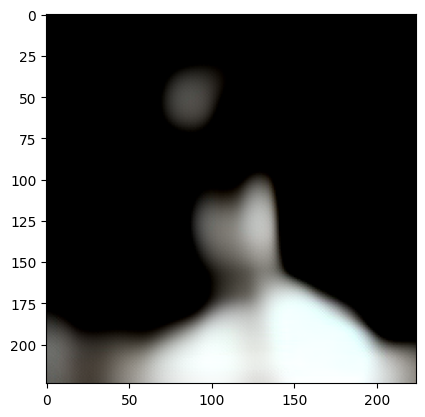

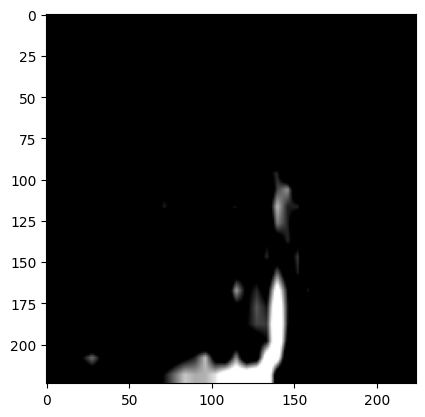

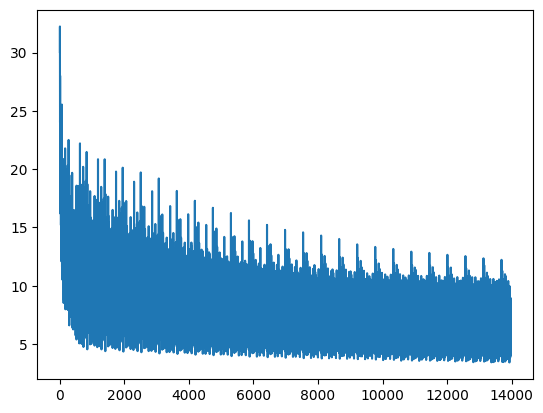

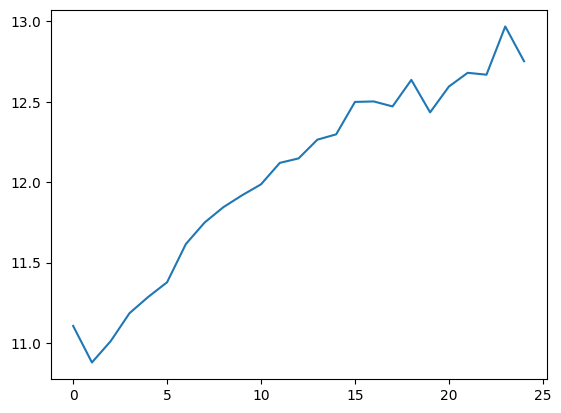

 25%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 25/100 [6:53:09<20:31:08, 984.91s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a13dd50>, test/blurry_pixcorr=0.462, test/loss=12.8, test/loss_clip_total=0.321, test/loss_prior=0.414, test/num_steps=25, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.904, train/blurry_pixcorr=0.868, train/bwd_pct_correct=0.999, train/fwd_pct_correct=1, train/loss=5.78, train/loss_

[E25/100 I0/559]
  Loss 7.231127738952637
[E25/100 I50/559]
  Loss 4.80733060836792
[E25/100 I100/559]
  Loss 8.003002166748047
[E25/100 I150/559]
  Loss 5.038188457489014
[E25/100 I200/559]
  Loss 7.172091484069824
[E25/100 I250/559]
  Loss 4.850114822387695
[E25/100 I300/559]
  Loss 4.28724479675293
[E25/100 I350/559]
  Loss 5.096466064453125
[E25/100 I400/559]
  Loss 4.6738691329956055
[E25/100 I450/559]
  Loss 6.867980003356934
[E25/100 I500/559]
  Loss 4.040805339813232
[E25/100 I550/559]
  Loss 6.646821022033691

---Evaluating---



 25%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 25/100 [7:09:24<20:31:08, 984.91s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a43c390>, test/blurry_pixcorr=0.462, test/loss=12.9, test/loss_clip_total=0.309, test/loss_prior=0.419, test/num_steps=26, test/test_bwd_pct_correct=0.885, test/test_fwd_pct_correct=0.917, train/blurry_pixcorr=0.871, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.72, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 25 / 100


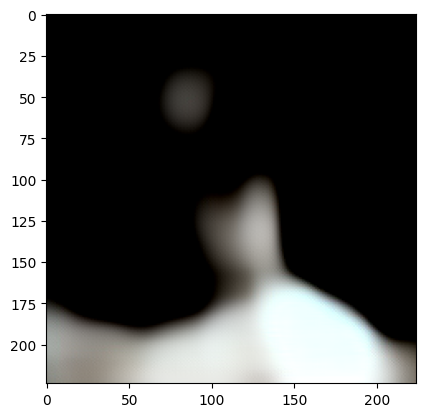

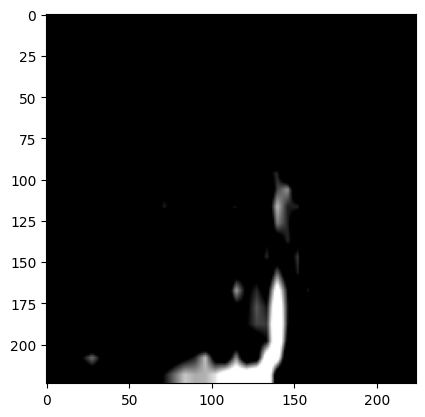

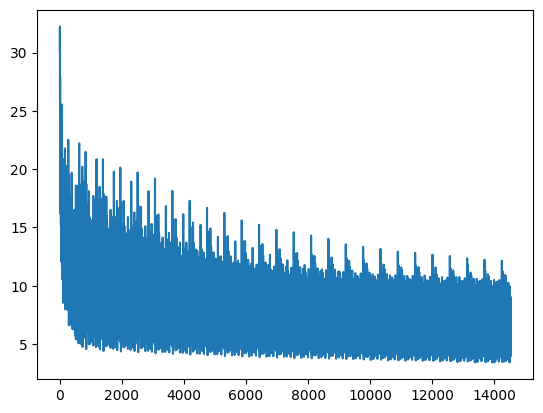

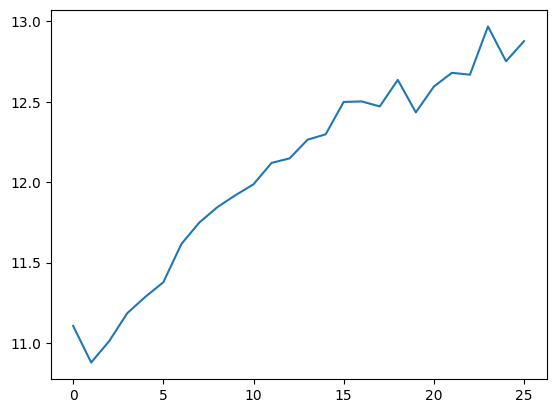

 26%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                      | 26/100 [7:09:31<20:13:44, 984.11s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a43c390>, test/blurry_pixcorr=0.462, test/loss=12.9, test/loss_clip_total=0.309, test/loss_prior=0.419, test/num_steps=26, test/test_bwd_pct_correct=0.885, test/test_fwd_pct_correct=0.917, train/blurry_pixcorr=0.871, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.72, train/loss

[E26/100 I0/559]
  Loss 7.192167282104492
[E26/100 I50/559]
  Loss 4.781918048858643
[E26/100 I100/559]
  Loss 7.939417839050293
[E26/100 I150/559]
  Loss 4.965966701507568
[E26/100 I200/559]
  Loss 7.068205833435059
[E26/100 I250/559]
  Loss 4.795388221740723
[E26/100 I300/559]
  Loss 4.23409366607666
[E26/100 I350/559]
  Loss 5.008728981018066
[E26/100 I400/559]
  Loss 4.6287994384765625
[E26/100 I450/559]
  Loss 6.771360874176025
[E26/100 I500/559]
  Loss 3.937998056411743
[E26/100 I550/559]
  Loss 6.637825012207031

---Evaluating---



 26%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                     | 26/100 [7:25:47<20:13:44, 984.11s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b6492d0>, test/blurry_pixcorr=0.466, test/loss=12.6, test/loss_clip_total=0.311, test/loss_prior=0.408, test/num_steps=27, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.921, train/blurry_pixcorr=0.875, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.65, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 26 / 100


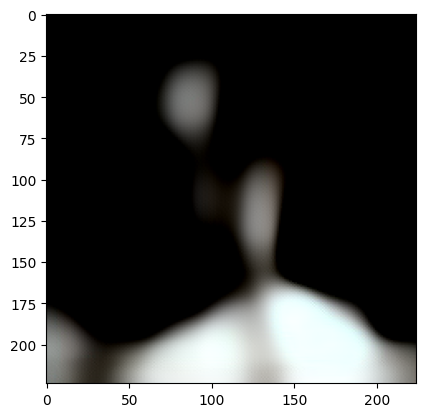

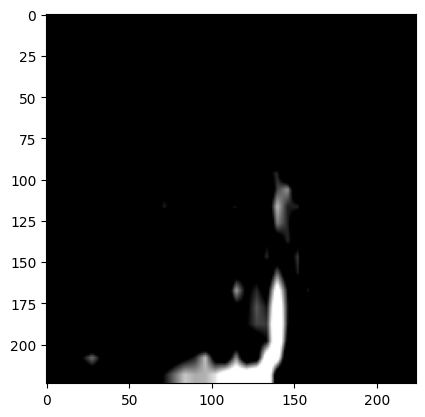

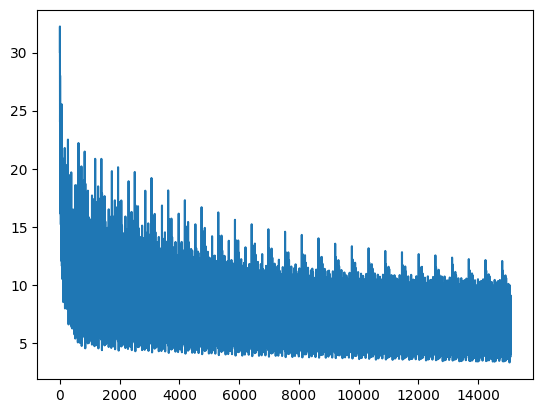

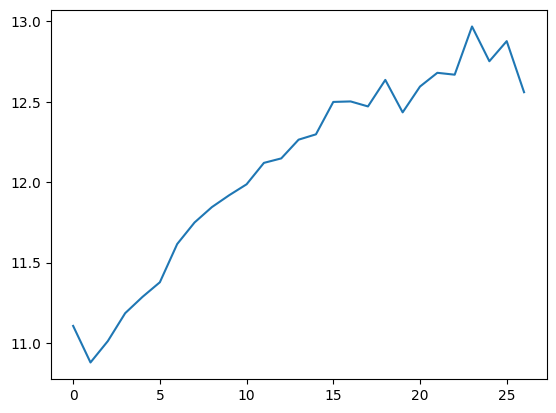

 27%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                               | 27/100 [7:25:54<19:56:54, 983.76s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b6492d0>, test/blurry_pixcorr=0.466, test/loss=12.6, test/loss_clip_total=0.311, test/loss_prior=0.408, test/num_steps=27, test/test_bwd_pct_correct=0.888, test/test_fwd_pct_correct=0.921, train/blurry_pixcorr=0.875, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.65, train/loss_b

[E27/100 I0/559]
  Loss 7.18688440322876
[E27/100 I50/559]
  Loss 4.687787055969238
[E27/100 I100/559]
  Loss 7.830552101135254
[E27/100 I150/559]
  Loss 4.86307954788208
[E27/100 I200/559]
  Loss 7.066847801208496
[E27/100 I250/559]
  Loss 4.737517356872559
[E27/100 I300/559]
  Loss 4.204514503479004
[E27/100 I350/559]
  Loss 4.915553569793701
[E27/100 I400/559]
  Loss 4.542829990386963
[E27/100 I450/559]
  Loss 6.732637882232666
[E27/100 I500/559]
  Loss 3.9109630584716797
[E27/100 I550/559]
  Loss 6.5641255378723145

---Evaluating---



 27%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                               | 27/100 [7:42:10<19:56:54, 983.76s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2aa699d0>, test/blurry_pixcorr=0.467, test/loss=12.8, test/loss_clip_total=0.309, test/loss_prior=0.416, test/num_steps=28, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.921, train/blurry_pixcorr=0.878, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.58, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 27 / 100


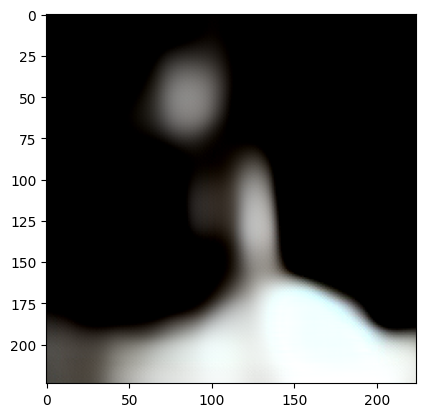

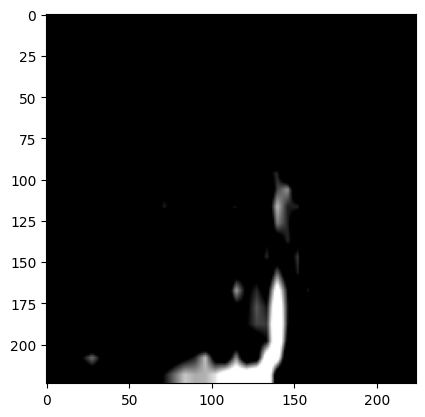

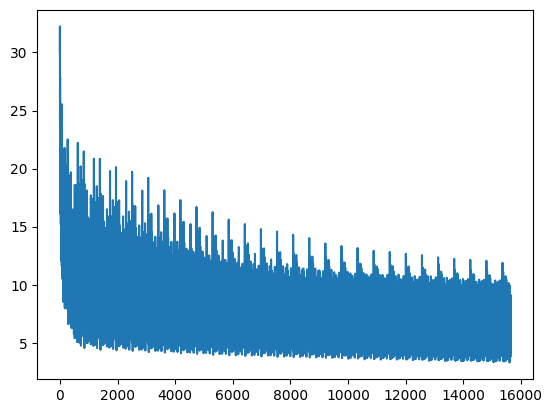

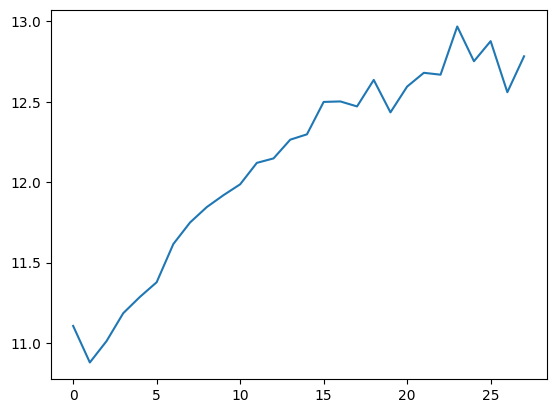

 28%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                         | 28/100 [7:42:17<19:40:08, 983.45s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2aa699d0>, test/blurry_pixcorr=0.467, test/loss=12.8, test/loss_clip_total=0.309, test/loss_prior=0.416, test/num_steps=28, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.921, train/blurry_pixcorr=0.878, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.58, train/loss_b

[E28/100 I0/559]
  Loss 7.157210826873779
[E28/100 I50/559]
  Loss 4.661447525024414
[E28/100 I100/559]
  Loss 7.706319808959961
[E28/100 I150/559]
  Loss 4.84169340133667
[E28/100 I200/559]
  Loss 7.00181770324707
[E28/100 I250/559]
  Loss 4.76279354095459
[E28/100 I300/559]
  Loss 4.196915149688721
[E28/100 I350/559]
  Loss 4.88490104675293
[E28/100 I400/559]
  Loss 4.535614013671875
[E28/100 I450/559]
  Loss 6.733560085296631
[E28/100 I500/559]
  Loss 3.862173318862915
[E28/100 I550/559]
  Loss 6.584294319152832

---Evaluating---



 28%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                           | 28/100 [7:58:31<19:40:08, 983.45s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2aa3e1d0>, test/blurry_pixcorr=0.467, test/loss=12.8, test/loss_clip_total=0.314, test/loss_prior=0.417, test/num_steps=29, test/test_bwd_pct_correct=0.892, test/test_fwd_pct_correct=0.919, train/blurry_pixcorr=0.881, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.52, train/loss


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 28 / 100


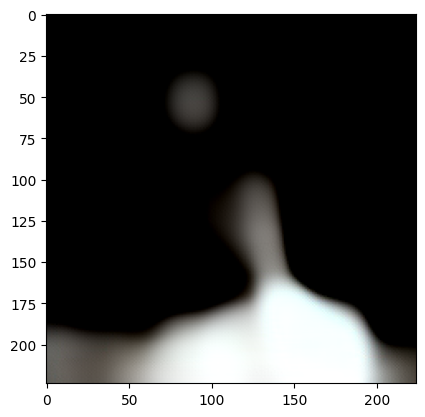

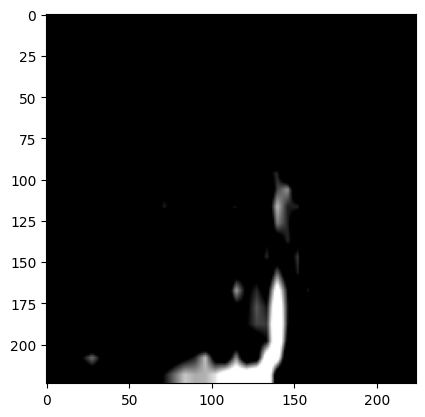

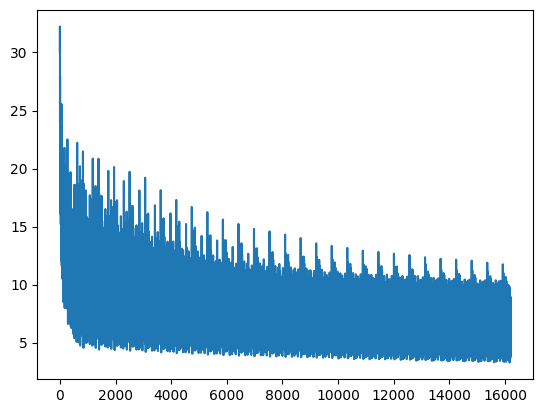

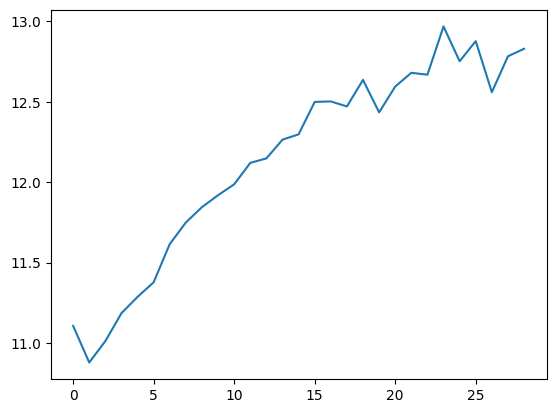

 29%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                     | 29/100 [7:58:38<19:23:10, 982.97s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2aa3e1d0>, test/blurry_pixcorr=0.467, test/loss=12.8, test/loss_clip_total=0.314, test/loss_prior=0.417, test/num_steps=29, test/test_bwd_pct_correct=0.892, test/test_fwd_pct_correct=0.919, train/blurry_pixcorr=0.881, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.52, train/loss

[E29/100 I0/559]
  Loss 7.0930023193359375
[E29/100 I50/559]
  Loss 4.598896026611328
[E29/100 I100/559]
  Loss 7.564105033874512
[E29/100 I150/559]
  Loss 4.7984843254089355
[E29/100 I200/559]
  Loss 6.93996524810791
[E29/100 I250/559]
  Loss 4.699981689453125
[E29/100 I300/559]
  Loss 4.171738147735596
[E29/100 I350/559]
  Loss 4.855316162109375
[E29/100 I400/559]
  Loss 4.525359153747559
[E29/100 I450/559]
  Loss 6.763022422790527
[E29/100 I500/559]
  Loss 3.882615089416504
[E29/100 I550/559]
  Loss 6.486449241638184

---Evaluating---



 29%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                    | 29/100 [8:14:54<19:23:10, 982.97s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a8d5110>, test/blurry_pixcorr=0.471, test/loss=12.9, test/loss_clip_total=0.318, test/loss_prior=0.421, test/num_steps=30, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.913, train/blurry_pixcorr=0.884, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.49, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/ep29 ckpt!---




---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 29 / 100


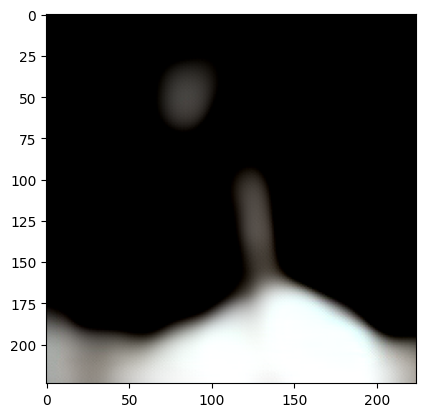

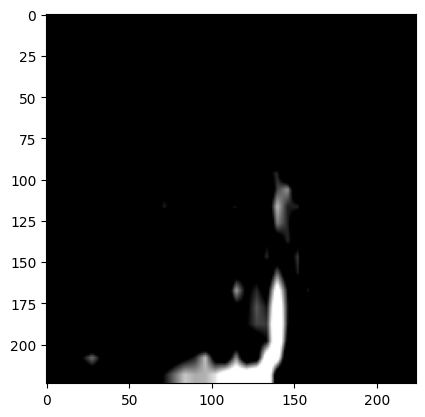

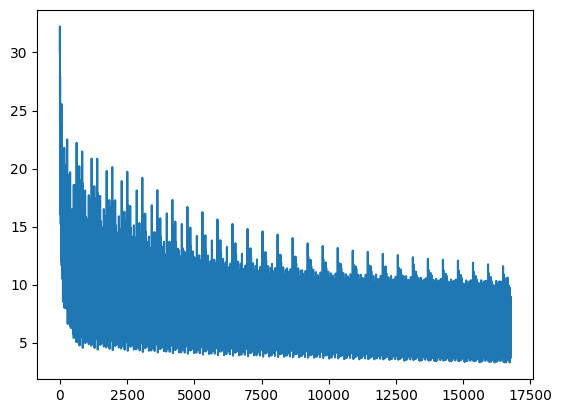

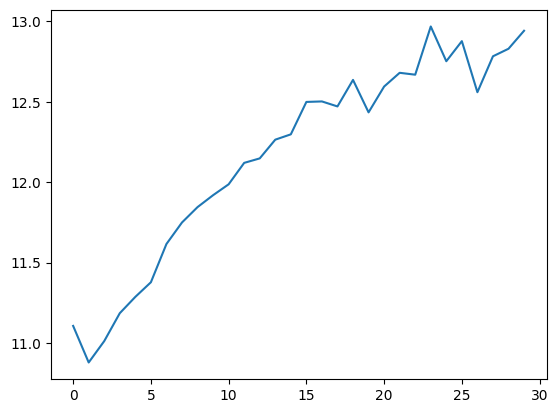

 30%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                              | 30/100 [8:15:09<19:09:29, 985.28s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a8d5110>, test/blurry_pixcorr=0.471, test/loss=12.9, test/loss_clip_total=0.318, test/loss_prior=0.421, test/num_steps=30, test/test_bwd_pct_correct=0.877, test/test_fwd_pct_correct=0.913, train/blurry_pixcorr=0.884, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.49, train/loss_

[E30/100 I0/559]
  Loss 7.060766220092773
[E30/100 I50/559]
  Loss 4.547839164733887
[E30/100 I100/559]
  Loss 7.630409240722656
[E30/100 I150/559]
  Loss 4.724125862121582
[E30/100 I200/559]
  Loss 6.920250415802002
[E30/100 I250/559]
  Loss 4.628720760345459
[E30/100 I300/559]
  Loss 4.126047611236572
[E30/100 I350/559]
  Loss 4.8009257316589355
[E30/100 I400/559]
  Loss 4.484912395477295
[E30/100 I450/559]
  Loss 6.673299312591553
[E30/100 I500/559]
  Loss 3.8590660095214844
[E30/100 I550/559]
  Loss 6.333833694458008

---Evaluating---



 30%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                               | 30/100 [8:31:26<19:09:29, 985.28s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b596710>, test/blurry_pixcorr=0.468, test/loss=12.9, test/loss_clip_total=0.319, test/loss_prior=0.42, test/num_steps=31, test/test_bwd_pct_correct=0.871, test/test_fwd_pct_correct=0.915, train/blurry_pixcorr=0.886, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.44, train/loss_


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 30 / 100


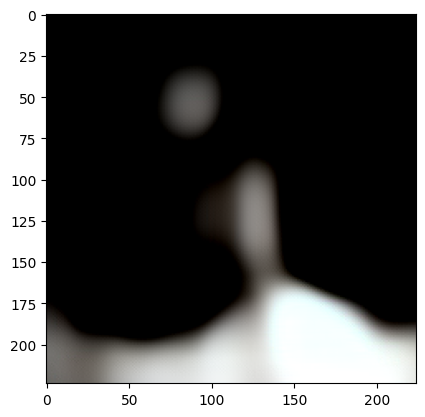

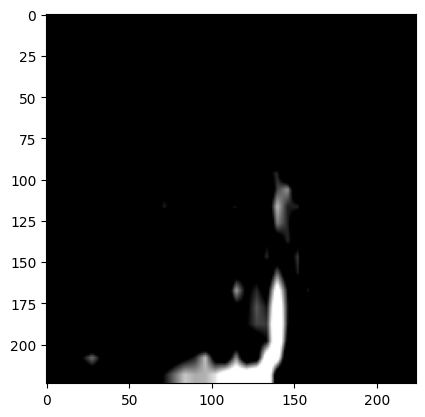

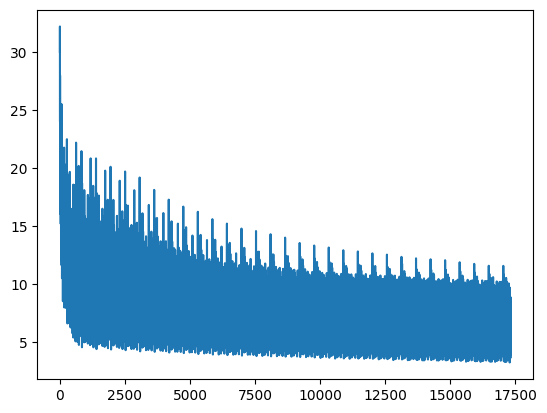

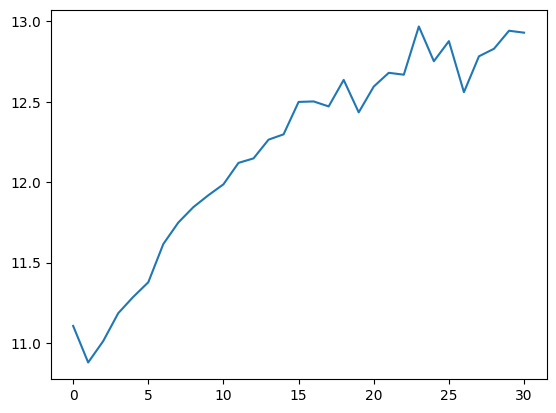

 31%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                         | 31/100 [8:31:33<18:52:30, 984.80s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2b596710>, test/blurry_pixcorr=0.468, test/loss=12.9, test/loss_clip_total=0.319, test/loss_prior=0.42, test/num_steps=31, test/test_bwd_pct_correct=0.871, test/test_fwd_pct_correct=0.915, train/blurry_pixcorr=0.886, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.44, train/loss_

[E31/100 I0/559]
  Loss 6.978141784667969
[E31/100 I50/559]
  Loss 4.426450729370117
[E31/100 I100/559]
  Loss 7.663148403167725
[E31/100 I150/559]
  Loss 4.701109409332275
[E31/100 I200/559]
  Loss 6.915258884429932
[E31/100 I250/559]
  Loss 4.577069282531738
[E31/100 I300/559]
  Loss 4.051490783691406
[E31/100 I350/559]
  Loss 4.739925861358643
[E31/100 I400/559]
  Loss 4.410566329956055
[E31/100 I450/559]
  Loss 6.605137348175049
[E31/100 I500/559]
  Loss 3.7862281799316406
[E31/100 I550/559]
  Loss 6.32588005065918

---Evaluating---



 31%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                         | 31/100 [8:47:51<18:52:30, 984.80s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a2aa6d0>, test/blurry_pixcorr=0.468, test/loss=13, test/loss_clip_total=0.319, test/loss_prior=0.423, test/num_steps=32, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.912, train/blurry_pixcorr=0.889, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.37, train/loss_b


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 31 / 100


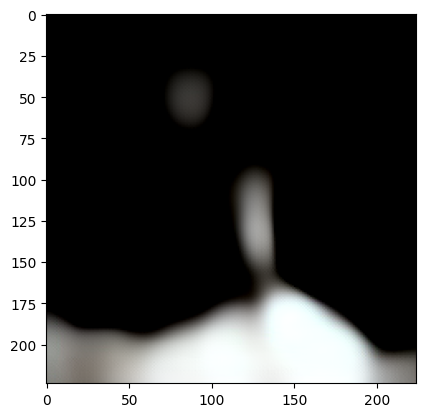

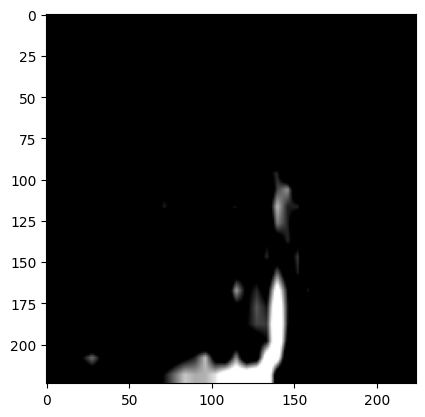

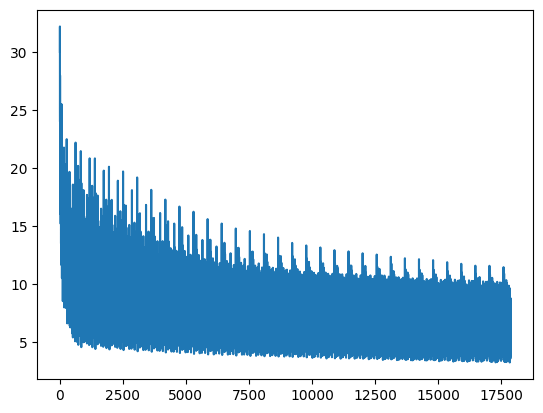

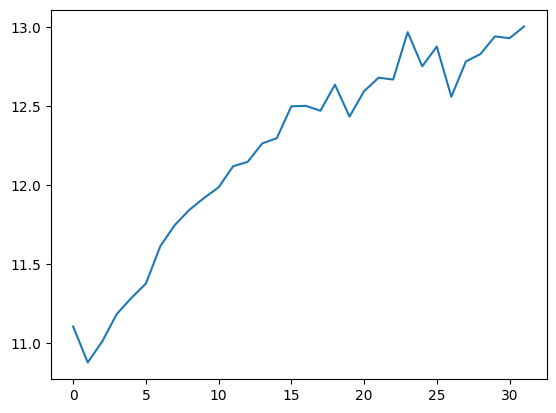

 32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                   | 32/100 [8:47:58<18:36:15, 984.94s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a2aa6d0>, test/blurry_pixcorr=0.468, test/loss=13, test/loss_clip_total=0.319, test/loss_prior=0.423, test/num_steps=32, test/test_bwd_pct_correct=0.875, test/test_fwd_pct_correct=0.912, train/blurry_pixcorr=0.889, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.37, train/loss_b

[E32/100 I0/559]
  Loss 6.9525146484375
[E32/100 I50/559]
  Loss 4.4081711769104
[E32/100 I100/559]
  Loss 7.413908958435059
[E32/100 I150/559]
  Loss 4.698760509490967
[E32/100 I200/559]
  Loss 6.945523738861084
[E32/100 I250/559]
  Loss 4.517784118652344
[E32/100 I300/559]
  Loss 4.030158042907715
[E32/100 I350/559]
  Loss 4.706419944763184
[E32/100 I400/559]
  Loss 4.351362228393555
[E32/100 I450/559]
  Loss 6.575882434844971
[E32/100 I500/559]
  Loss 3.7127530574798584
[E32/100 I550/559]
  Loss 6.442874431610107

---Evaluating---



 32%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                    | 32/100 [9:04:14<18:36:15, 984.94s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a3c8190>, test/blurry_pixcorr=0.469, test/loss=13.1, test/loss_clip_total=0.333, test/loss_prior=0.425, test/num_steps=33, test/test_bwd_pct_correct=0.871, test/test_fwd_pct_correct=0.923, train/blurry_pixcorr=0.892, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.32, train/los


---saved /scratch/izar/sobotka/csng/mindeye/train_logs/csng_mouse_v1__17-03-25_01-23/last ckpt!---

Finished epoch 32 / 100


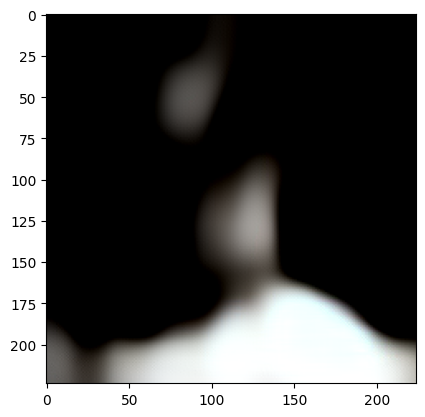

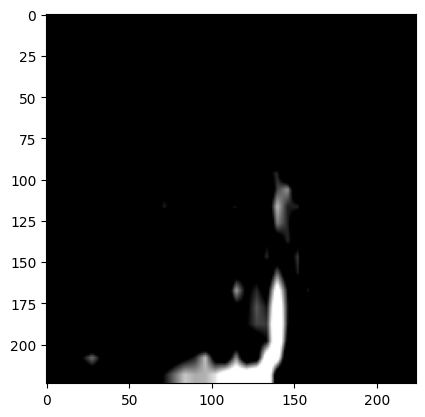

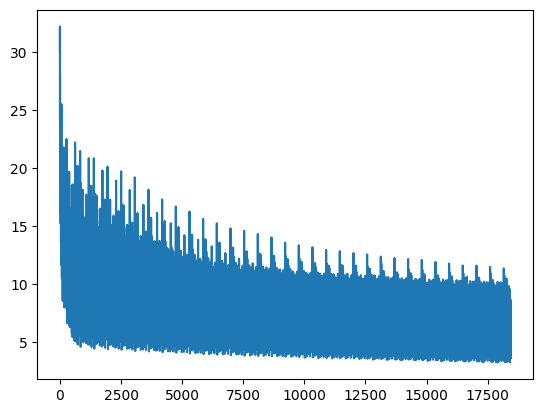

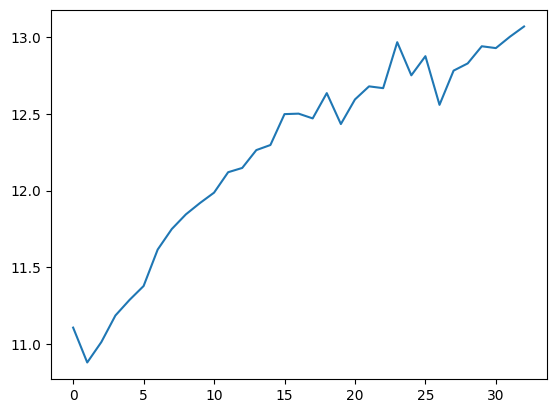

 33%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                              | 33/100 [9:04:21<18:19:02, 984.22s/it, test/blur_recons=<wandb.sdk.data_types.image.Image object at 0x7f0c2a3c8190>, test/blurry_pixcorr=0.469, test/loss=13.1, test/loss_clip_total=0.333, test/loss_prior=0.425, test/num_steps=33, test/test_bwd_pct_correct=0.871, test/test_fwd_pct_correct=0.923, train/blurry_pixcorr=0.892, train/bwd_pct_correct=1, train/fwd_pct_correct=1, train/loss=5.32, train/los

[E33/100 I0/559]
  Loss 6.973351001739502
[E33/100 I50/559]
  Loss 4.366246700286865
[E33/100 I100/559]
  Loss 7.488958358764648
[E33/100 I150/559]
  Loss 4.595390796661377
[E33/100 I200/559]
  Loss 6.825163841247559
[E33/100 I250/559]
  Loss 4.461203098297119
[E33/100 I300/559]
  Loss 4.018239974975586
[E33/100 I350/559]
  Loss 4.677728652954102


KeyboardInterrupt: 

In [ ]:
### tracking
epoch = 0
losses, test_losses, lrs = [], [], []
best = {"loss": 1e9, "epoch": 0}
torch.cuda.empty_cache()

### optimization
mse = nn.MSELoss()
l1 = nn.L1Loss()
cfg["model"]["cos_anneal_start"] = 0.004
cfg["model"]["cos_anneal_end"] = 0.0075
soft_loss_temps = utils.cosine_anneal(
    cfg["model"]["cos_anneal_start"],
    cfg["model"]["cos_anneal_end"],
    cfg["model"]["num_epochs"] - int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"])
)

### run
model.to(cfg["device"])
progress_bar = tqdm(range(epoch, cfg["model"]["num_epochs"]), ncols=1200, disable=False)
seed_all(cfg["seed"])
for epoch in progress_bar:
    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    recon_cossim = 0.
    recon_mse = 0.
    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    loss_prior_total = 0.
    blurry_pixcorr = 0.

    train_dl = get_dataloaders(config=cfg)[0]["train"][cfg["data_name"]]

    ### train
    model.train()
    for train_i, batch in enumerate(train_dl):
        if train_i % 50 == 0:
            print(f"[E{epoch}/{cfg['model']['num_epochs']} I{train_i}/{cfg['model']['num_iterations_per_epoch']}]")
        with torch.cuda.amp.autocast(dtype=cfg["data_type"]):
            optimizer.zero_grad()
            loss = 0.

            ### select data
            voxel_list = [dp["resp"].unsqueeze(1).to(cfg["device"]) for dp in batch]  # (B, 1, num_voxels = num_of_neurons)
            image = img_tform(torch.cat([dp["stim"] for dp in batch], dim=0).to(cfg["device"]))  # (B, 3, 224, 224)

            ### augment image
            if cfg["model"]["use_image_aug"]: 
                image = img_augment(image)

            if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                perm_list = [perm_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                perm = torch.cat(perm_list, dim=0)
                betas_list = [betas_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                betas = torch.cat(betas_list, dim=0).to(cfg["data_type"])
                select_list = [select_iters[f"subj0{s}_iter{train_i}"].detach().to(cfg["device"]) for s in cfg["model"]["subj_list"]]
                select = torch.cat(select_list, dim=0)

            ### map voxels to clip space
            voxel_ridge = torch.cat([model.ridge(voxel_list[si], si) for si, s in enumerate(cfg["model"]["subj_list"])], dim=0)
            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            ### map GT image to clip space
            clip_target = clip_img_embedder(image)
            assert not torch.any(torch.isnan(clip_target))

            ### normalize clip embeddings
            if cfg["model"]["clip_scale"] > 0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if cfg["model"]["use_prior"]:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                if torch.isnan(loss_prior).any():
                    print(f"  Loss prior is NaN, skipping...")
                    del backbone, clip_voxels, blurry_image_enc_, clip_target, clip_voxels_norm, clip_target_norm, loss_prior, prior_out
                    import gc
                    gc.collect()
                    torch.cuda.empty_cache()
                    continue
                for i in range(3):
                    if torch.isnan(loss_prior).any():
                        print(f"  Loss prior is NaN, trying again...")
                        del loss_prior, prior_out
                        torch.cuda.empty_cache()
                        loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                    else:
                        break

                loss_prior_total += loss_prior.item()
                loss_prior *= cfg["model"]["prior_scale"]
                loss += loss_prior

                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if cfg["model"]["clip_scale"] > 0:
                if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)
                else:
                    epoch_temp = soft_loss_temps[epoch - int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"])]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp,
                    )

                loss_clip_total += loss_clip.item()
                loss_clip *= cfg["model"]["clip_scale"]
                loss += loss_clip

            if cfg["model"]["blurry_recon"]:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                # image_enc = autoenc.encode(2 * image - 1).latent_dist.mode() * 0.18215
                image_enc = autoenc.encode(image).latent_dist.mode() * 0.18215  # already z-scored
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(cfg["model"]["mixup_pct"] * cfg["model"]["num_epochs"]):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                # image_norm = (image - mean) / std
                image_norm = image  # already z-scored
                # print(f"  Blurring Aug {image_norm.shape}")
                # image_aug = (blur_augs(image) - mean) / std
                image_aug = blur_augs(image)  # already z-scored
                _, cnx_embeds = cnx(image_norm)
                _, cnx_aug_embeds = cnx(image_aug)

                cont_loss = utils.soft_cont_loss(
                    nn.functional.normalize(transformer_feats.reshape(-1, transformer_feats.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    nn.functional.normalize(cnx_aug_embeds.reshape(-1, cnx_embeds.shape[-1]), dim=-1),
                    temp=0.2)
                loss_blurry_cont_total += cont_loss.item()

                loss += (loss_blurry + 0.1 * cont_loss) * cfg["model"]["blur_scale"] #/.18215

            if cfg["model"]["clip_scale"]>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if cfg["model"]["blurry_recon"]:
                with torch.no_grad():
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    random_samps = np.random.choice(np.arange(len(image)), size=max(len(image)//5, 1), replace=False)
                    # blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample)
                    pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    blurry_pixcorr += pixcorr.item()

            if train_i % 50 == 0:
                print(f"  Loss {loss.item()}")
            utils.check_loss(loss)
            # accelerator.backward(loss)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if cfg["model"]["optimization"]["lr_scheduler_type"] is not None:
                lr_scheduler.step()

            optimizer.zero_grad()
            torch.cuda.empty_cache()

    ### evaluate
    print("\n---Evaluating---\n")
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=cfg["data_type"]):
        n_minibatches = 0
        test_loss=0.
        test_loss_clip_total = 0.
        test_loss_prior_total = 0.
        test_blurry_pixcorr = 0.
        test_fwd_percent_correct = 0.
        test_bwd_percent_correct = 0.
        eval_dl = get_dataloaders(config=cfg)[0]["val"][cfg["data_name"]]
        for batch in eval_dl:
            voxel_list = [dp["resp"].unsqueeze(1).to(cfg["device"]) for dp in batch]  # (B, 1, num_voxels = num_of_neurons)
            image = img_tform(torch.cat([dp["stim"] for dp in batch], dim=0).to(cfg["device"]))  # (B, 3, 224, 224)

            voxel_ridge = torch.cat([model.ridge(voxel_list[si], si) for si, s in enumerate(cfg["model"]["subj_list"])], dim=0)
            backbone, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)

            clip_target = clip_img_embedder(image.float())
            if cfg["model"]["clip_scale"]>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)

            if cfg["model"]["use_prior"]:
                loss_prior, _ = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                test_loss_prior_total += loss_prior.item()
                loss_prior *= cfg["model"]["prior_scale"]
                test_loss += loss_prior

            if cfg["model"]["clip_scale"]>0:
                loss_clip = utils.soft_clip_loss(
                    clip_voxels_norm,
                    clip_target_norm,
                    temp=.006,
                )

                test_loss_clip_total += loss_clip.item()
                loss_clip = loss_clip * cfg["model"]["clip_scale"]
                test_loss += loss_clip

            if cfg["model"]["blurry_recon"]:
                image_enc_pred, _ = blurry_image_enc_
                # blurry_recon_images = (autoenc.decode(image_enc_pred/0.18215).sample / 2 + 0.5).clamp(0,1)
                blurry_recon_images = (autoenc.decode(image_enc_pred/0.18215).sample)
                pixcorr = utils.pixcorr(image, blurry_recon_images)
                test_blurry_pixcorr += pixcorr.item()

            if cfg["model"]["clip_scale"]>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            n_minibatches += 1

        test_loss /= n_minibatches
        test_loss_clip_total /= n_minibatches
        test_loss_prior_total /= n_minibatches
        test_blurry_pixcorr /= n_minibatches
        test_fwd_percent_correct /= n_minibatches
        test_bwd_percent_correct /= n_minibatches

        utils.check_loss(test_loss)                
        test_losses.append(test_loss.item())

        if test_loss.item() < best["loss"]:
            save_ckpt(f'best')
            best["loss"] = test_loss.item()
            best["epoch"] = epoch

        logs = {
            "train/loss": np.mean(losses[-(train_i+1):]),
            "test/loss": test_loss.item(),
            "train/lr": lrs[-1],
            "train/num_steps": len(losses),
            "test/num_steps": len(test_losses),
            "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
            "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
            "test/test_fwd_pct_correct": test_fwd_percent_correct,
            "test/test_bwd_pct_correct": test_bwd_percent_correct,
            "train/loss_clip_total": loss_clip_total / (train_i + 1),
            "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
            "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
            "test/loss_clip_total": test_loss_clip_total,
            "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
            "test/blurry_pixcorr": test_blurry_pixcorr,
            "train/recon_cossim": recon_cossim / (train_i + 1),
            "train/recon_mse": recon_mse / (train_i + 1),
            "train/loss_prior": loss_prior_total / (train_i + 1),
            "test/loss_prior": test_loss_prior_total,
        }

        # if finished training, save jpg recons if they exist
        if (epoch == cfg["model"]["num_epochs"]-1) or (epoch % cfg["model"]["ckpt_interval"] == 0):
            if cfg["model"]["blurry_recon"]:    
                # image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                image_enc = autoenc.encode(image[:4]).latent_dist.mode() * 0.18215  # already z-scored
                # transform blurry recon latents to images and plot it
                fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                jj=-1
                for j in [0,1,2,3]:
                    jj+=1
                    # axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].imshow(utils.torch_to_Image(autoenc.decode(image_enc[[j]]/0.18215).sample))
                    axes[jj].axis('off')
                    jj+=1
                    # axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                    axes[jj].imshow(utils.torch_to_Image(autoenc.decode(image_enc_pred[[j]]/0.18215).sample))
                    axes[jj].axis('off')

                if wandb_log:
                    logs[f"test/blur_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                    plt.close()
                else:
                    plt.show()

        progress_bar.set_postfix(**logs)

        if wandb_log: wandb.log(logs)

    # Save model checkpoint and reconstruct
    # if (ckpt_saving) and (epoch % ckpt_interval == 0):
    if (epoch + 1) % 5 == 0:
        save_ckpt(f'ep{epoch}')
    save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    # accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    print(f"Finished epoch {epoch} / {cfg['model']['num_epochs']}")
    
    plt.imshow(blurry_recon_images[0].permute(1,2,0).cpu().detach().to(torch.float32))
    plt.show()
    plt.imshow(image[0].permute(1,2,0).cpu().detach().to(torch.float32))
    plt.show()
    plt.plot(losses)
    plt.show()
    plt.plot(test_losses)
    plt.show()

print("\n===Finished!===\n")
save_ckpt(f'last')

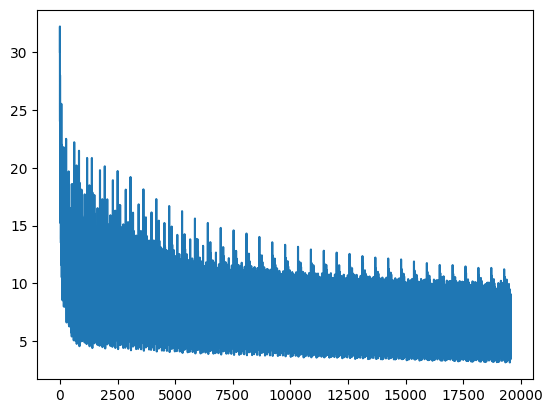

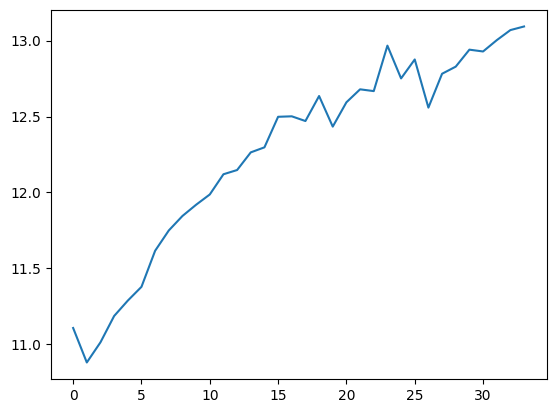

In [ ]:
plt.plot(losses)
plt.show()
plt.plot(test_losses)
plt.show()